**Импорт библиотек**

In [1]:
pip install -U scikit-learn phik shap matplotlib==3.7.3 numpy==1.22 seaborn==0.11.1 -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import phik
import shap
from scipy import stats
from IPython.display import display
import transformers

import seaborn as sns
import matplotlib.pyplot as plt

# модули для работы с моделями:

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay



In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## **Загрузка данных**

Ознакомимся с данными их следующих таблиц:
1. market_file.csv
2. market_money.csv
3. market_time.csv
4. money.csv

In [4]:
# Функция для отображения части датасета и информации о нем
def show_info(df):
    display(df.head())
    df.info()

### market_file

Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [5]:
market_file = pd.read_csv('/datasets/market_file.csv')
show_info(market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Какие выводы можно сделать:**

Информация в датасете соответствует описанию. 

1300 строк, 13 столбцов  

Типы:
1. int - 7 столбцов:   
   * `id`, `Маркет_актив_тек_мес`, `Длительность`, `Средний_просмотр_категорий_за_визит`, 
   `Неоплаченные_продукты_штук_квартал`, `Ошибка_сервиса`, `Страниц_за_визит`
2. float - 2 столбца:   
   * `Маркет_актив_6_мес`, `Акционные_покупки`
3. object - 4 столбца:   
   * `Покупательская активность`, `Тип сервиса`, `Разрешить сообщать`, `Популярная_категория`


Нет пустых строк ни по одному из столбцов.  

На этапе предобработки данных необходимо:
1. изменить названия столбцов: 
  - заменить пробелы на нижнее подчеркивание
  - привести названия к нижнему регистру
2. Изменить значения:
  - Например, "стандартт" заменить на "стандарт", все остальные значения привести к нижнему регистру

### market_money

Данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [6]:
market_money = pd.read_csv('/datasets/market_money.csv')
show_info(market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Какие выводы можно сделать:**

3900 строк, 3 столбца  

Типы:
1. int - 1 столбец:   
   * `id`
2. float - 1 столбец:   
   * `Выручка`
3. object - 1 столбец:   
   * `Период`


Нет пустых строк ни по одному из столбцов.  

Информация в датасете соответствует описанию.  

На этапе предобработки данных необходимо:
1. Привести столбцы к нижнему регистру

### market_time

Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [7]:
market_time = pd.read_csv('/datasets/market_time.csv')
show_info(market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Какие выводы можно сделать:**

2600 строк, 3 столбца  

Типы:
1. int - 2 столбца:   
   * `id`, `минут`
2. object - 1 столбец:   
   * `Период`


Нет пустых строк ни по одному из столбцов.  

Информация в датасете соответствует описанию.  

На этапе предобработки данных необходимо:
1. Привести столбцы к нижнему регистру
2. Убрать опечатки в значениях столбца "Период" 

### money

Данные о среднемесячной прибыли покупателя за последние 3 месяца:  какую прибыль получает магазин от продаж каждому покупателю.

In [8]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
show_info(money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Какие выводы можно сделать:**

1300 строк, 2 столбца  

Типы:
1. int - 1 столбец:   
   * `id`
2. float - 1 столбец:   
   * `Прибыль`


Нет пустых строк ни по одному из столбцов.  

Информация в датасете соответствует описанию.  

На этапе предобработки данных необходимо:
1. привести столбцы к нижнему регистру

### **Вывод по 1 разделу**

Загружены и изучены данные по 4 датасетам.  
Каждый соответствует описанию задачи.  

Количество строк в 'market_money', 'market_time' и 'money' кратно количеству строк в 'market_file':
- не должно возникнуть проблем при объединении таблиц в дальнейшем.

Ни по одному из столбцов всех датасетов не обнаружено пустых строк.

Типы данных корректны.

**Изменения, которые необходимо выполнить на следующем этапе:**
- Привести названия столбцов к нижнему регистру
- Заменить пробелы на нижнее подчеркивание в названии столбцов
- Исправить некоторые значения на корректные (исправить опечатки)


## **Предобработка данных**

**Функции, которые будем использовать:**

Для поиска и просмотра явных дубликатов:

In [9]:
def duplicates_find(df):
    
    # Если дубликаты есть:    
    if df.duplicated().sum()>0:
        # Количество явных дубликатов
        print ('Количество явных дубликатов:', df.duplicated().sum())
        # Выводим на экран дубликаты
        display(df.loc[df.duplicated()])
    
    # Если дубликатов нет:
    else:
        print ('Явных дубликатов не найдено')

Для просмотра уникальных значений объектов типа Object:

In [10]:
def uniques(df):
    for column in df.columns:
        if df[column].dtype == 'O':
            print (f'{column}: \n {df[column].unique()} \n ')

### Приведение столбцов к нижнему регистру

In [11]:
for df in [market_file, market_money, market_time, money]:
    df.columns = df.columns.str.lower()
    
    # Выводим для проверки
    print (df.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


### market_file

**Замена наименований столбцов:**

In [12]:
# Заменяем пробелы на нижнее подчеркивание, приводим к нижнему регистру 
market_file.columns = market_file.columns.str.replace(' ', '_')

market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

* В дальнейшем так будет удобнее работать - все столбцы приведены к одному виду

**Пропуски**


In [13]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

* Отсутствуют.

**Явные дубликаты**

In [14]:
duplicates_find(market_file)

Явных дубликатов не найдено


**Неявные дубликаты**

In [15]:
# Уникальные значения в столбцах типа Object
uniques(market_file)

покупательская_активность: 
 ['Снизилась' 'Прежний уровень'] 
 
тип_сервиса: 
 ['премиум' 'стандартт' 'стандарт'] 
 
разрешить_сообщать: 
 ['да' 'нет'] 
 
популярная_категория: 
 ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 
 


Найдено:

Столбец 'тип_сервиса':
- Повторяется значения `стандартт`и `стандарт`


Столбец 'популярная_категория':
- Опечатка в `Косметика и аксесуары`

Исправим:

In [16]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['популярная_категория'] = market_file['популярная_категория'].replace(
    'Косметика и аксесуары', 'Косметика и аксессуары')

# Проверим уникальные значения после исправлений
print (market_file['тип_сервиса'].unique(), '\n \n', market_file['популярная_категория'].unique())

['премиум' 'стандарт'] 
 
 ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


**Дубликаты по ключевым столбцам**

In [17]:
# Количество дубликатов
print('Количество дубликатов по ключевым столбцам: ', market_file.drop('id', axis=1).duplicated().sum())

# Выведем дубликаты на экран
market_file[market_file.drop('id', axis=1).duplicated(keep=False)]

Количество дубликатов по ключевым столбцам:  11


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
337,215685,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11
338,215686,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
339,215687,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8
340,215688,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7
341,215689,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17
342,215690,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксессуары,2,1,1,6
343,215691,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
344,215692,Снизилась,стандарт,да,3.3,3,871,0.20,Техника для красоты и здоровья,2,4,2,17
345,215693,Снизилась,стандарт,да,5.6,5,574,0.28,Домашний текстиль,3,2,3,9
346,215694,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10


11 дубликатов.

**Возможная причина:**
Видно, что в данных, без учета id, строки с 547 по 557 - дубликаты строк с 337 по 347.  
Поскольку дубликаты идут последовательно друг за другом, можем предположить, что это не случайность. Возможно, в результате технической ошибки на каких-то этапах записи или других видах работы с данными значения задублировались с новыми `id`.

**Решение:**   
Пока оставим эти дубликаты.  
Как минимум, для начала надо ознакомиться с ситуацией по дубликатам в других таблицах.

На будущее сохраним дублированные id в виде списка:

In [18]:
strange_id = market_file[market_file.drop('id', axis=1).duplicated(keep=False)]['id']

### market_money

**Пропуски:**

In [19]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

* Пропусков нет.

**Явные дубликаты:**

In [20]:
duplicates_find(market_money)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [21]:
uniques(market_money)

период: 
 ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 
 


Значение "препредыдущий_месяц" может быть как опечаткой, так и обозначением месяца, прешествующего предыдущему.

Проверим равномерность распределения значений и заодно сравним количества строк в датасетах market_money и market_file:

In [22]:
# Проверяем равномерность распределения значений
display(market_money['период'].value_counts())

# Отображаем
print ('\nКол-во строк в market_money:', len(market_money), '\nКол-во строк в market_file: ', len(market_file))

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: период, dtype: int64


Кол-во строк в market_money: 3900 
Кол-во строк в market_file:  1300


Значения в датасете распределены равномерно (1/3 - доля каждого значения).   
Также количество строк датасета ровно в 3 раза больше, чем у market_file.  
* Из этого делаем вывод, что каждого из пользователей имеем выручку по 3 последним месяцам.

**Решение:**
* Оставляем значение "препредыдущий месяц" не измененным

### market_time

**Пропуски:**

In [23]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

* отсутствуют

**Явные дубликаты:**

In [24]:
duplicates_find(market_time)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [25]:
uniques(market_time)

период: 
 ['текущий_месяц' 'предыдцщий_месяц'] 
 


Исправим опечатку в значении "предыдцщий_месяц":

In [26]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

### money

**Пропуски:**

In [27]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

* Отсутствуют.

**Явные дубликаты:**

In [28]:
duplicates_find(money)

Явных дубликатов не найдено


### Обработка дубликатов по ключевым столбцам по 4 датасетам

Вернемся к дубликатам, обнаруженным по ключевым столбцам в п.2.2.   
Для списка id этих дубликатов посмотрим, дублируются ли значения их параметров в других таблицах.

Разделим значения в strange_id на две группы id:

In [29]:
strange_id_1 = strange_id[strange_id<215700]
strange_id_2 = strange_id[strange_id>215700]

Визуально сравним, насколько повторяют друг друга значения из списка strange_id, построив диаграммы рассеяния

In [30]:
# Функция построения диаграммы рассеяния
def plot_to_find_difference(df, y, title):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(12, 4)
    f.suptitle(title)
    sns.scatterplot(data = df.loc[df['id'].isin(strange_id_1)], x='id', y=y, palette='deep', ax=ax[0])
    sns.scatterplot(data = df.loc[df['id'].isin(strange_id_2)], x='id', y=y, palette='deep', ax=ax[1])  

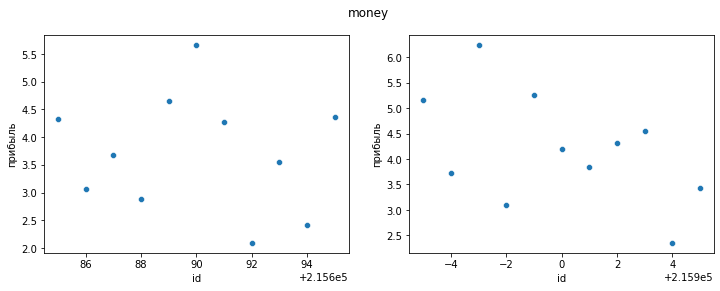

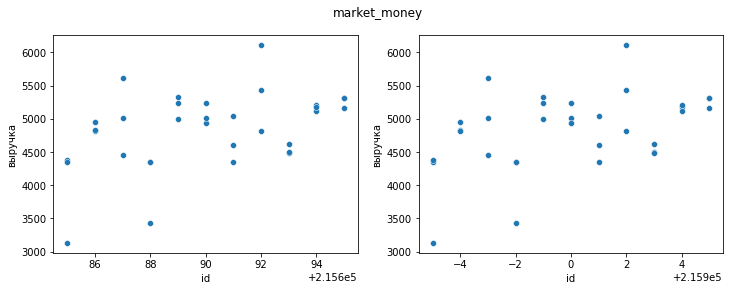

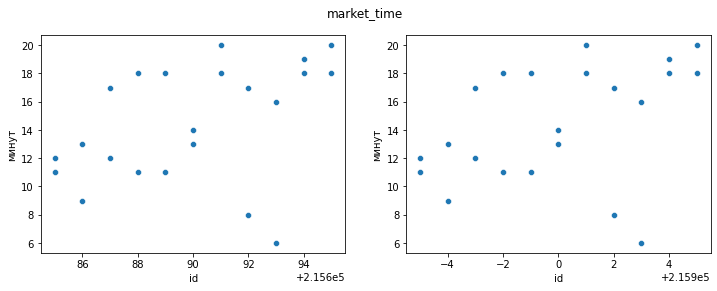

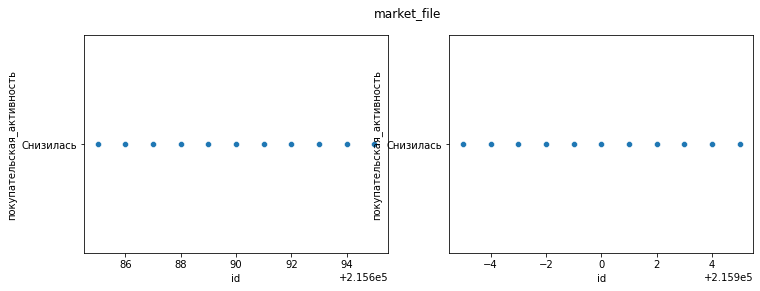

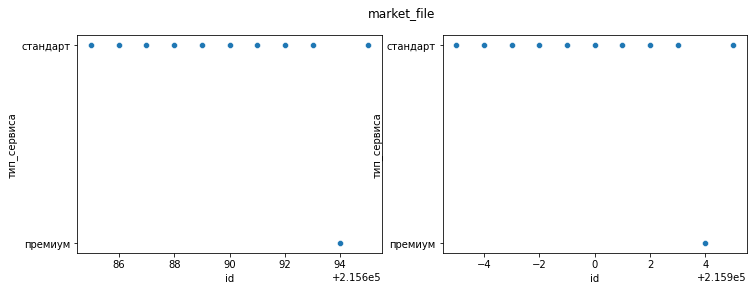

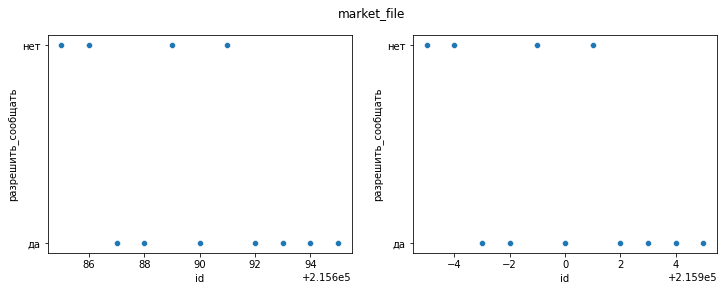

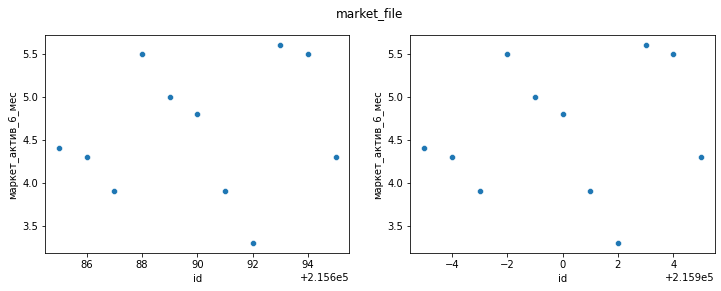

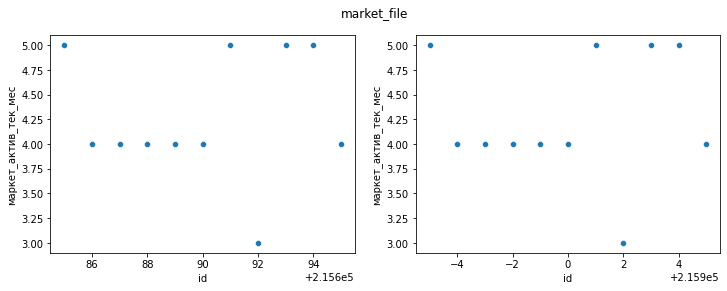

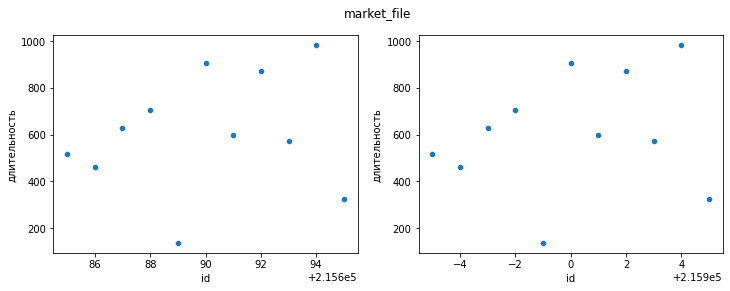

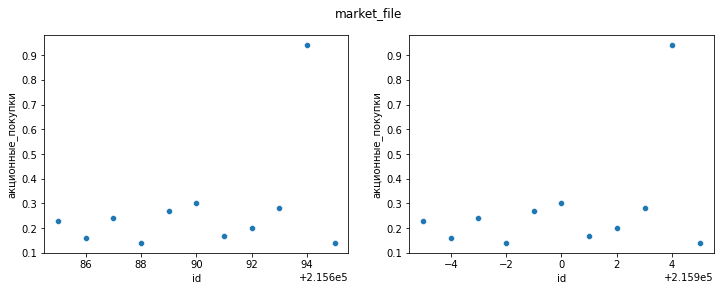

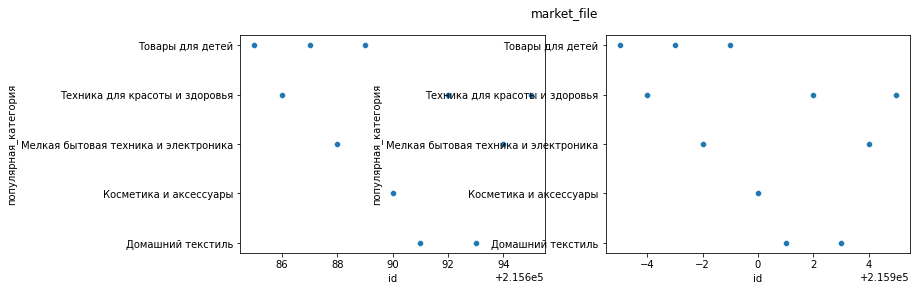

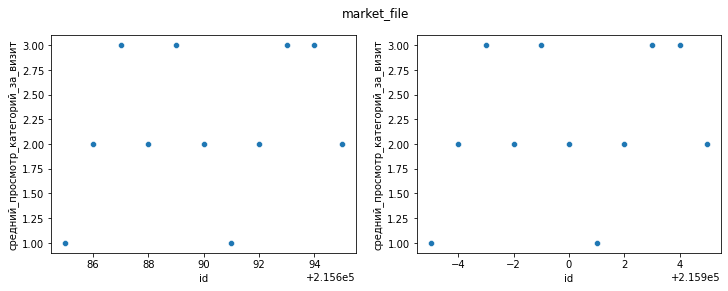

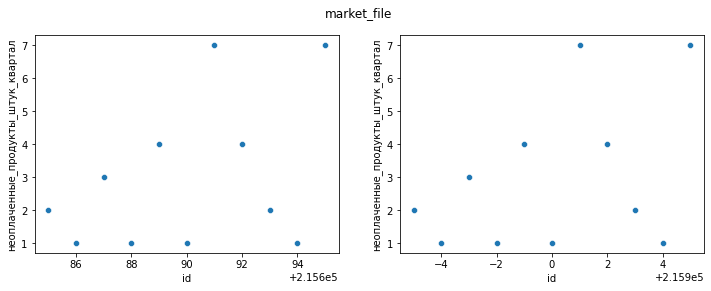

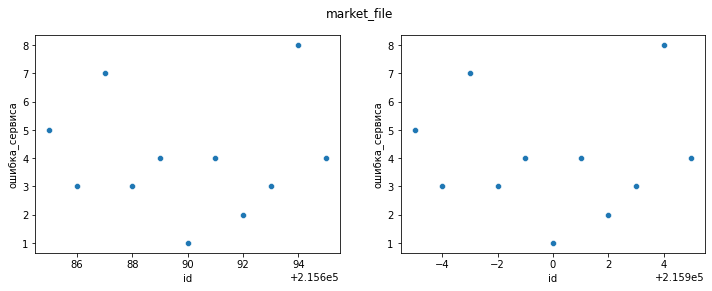

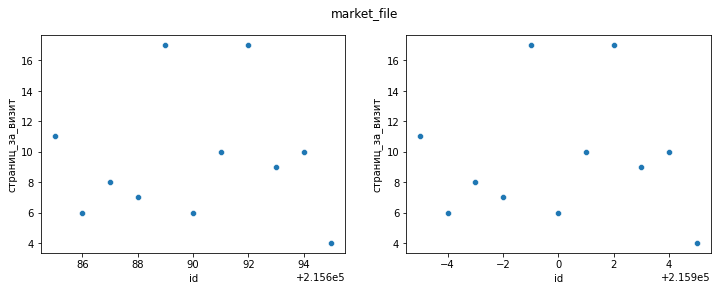

In [31]:
plot_to_find_difference(money, 'прибыль', 'money')
plot_to_find_difference(market_money, 'выручка', 'market_money')
plot_to_find_difference(market_time, 'минут', 'market_time')

for i in market_file.drop('id', axis=1).columns:
    plot_to_find_difference(market_file, i, 'market_file')

1. Видно, что значения идентичны в обозначенных id в market_file, market_money и market_time
2. Различаются - в money.

Изучим эти id более детально в money:

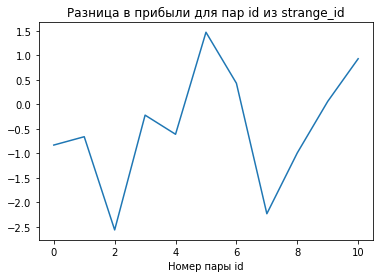

In [32]:
(money.query('id in @strange_id_1')['прибыль'].reset_index(drop=True) - 
 money.query('id in @strange_id_2')['прибыль'].reset_index(drop=True)).plot()
plt.title('Разница в прибыли для пар id из strange_id')
plt.xlabel('Номер пары id')
plt.show()

* При том, что у этих id совпадает выручка, видим довольно большую разницу в прибыли.  
Где-то заниженную, где-то завышенную.

Природа почти полностью дублированных, за исключением id и прибыли, строк не очевидна.  

**Возможная причина дублей:**   
Дополнительные строки были внесены специально с целью скорректировать суммарную прибыль в следствие какой-то ошибки, с которой сталкивались ранее.   
Например, изначально прибыль была посчитана неверно: обновленные данные внесли в датасеты, но старые не удалили, т.к. вместо добавления по id случайно присвоили им новые номера.

Следует уточнить этот вопрос у коллег.

**Стоит удалить все 22 строки:**   
* Среди повторяющихся признаков есть также и целевой - "покупательская активность". Это может привнести элемент переобучения в нашу моделью - она примет во внимание дважды одни и те же объекты.   
* Пользователи с идентичными значениями признаков, но разными значениями прибыли могут запутать нас в дальнейшем.
* Поскольку мы не знаем, какие данные истинные, стоит удалить обе группы.

Следует уточнить природу сходства этих строк у коллег, которые собирают данные, и потом, по мере необходимости, внести корректировки в выборки.

Посчитаем, какой процент датасета занимают пользователи из списка:

In [33]:
len(strange_id) / len(market_file)

0.016923076923076923

* Не так много, 1.7%

**Удаление строк:**

In [34]:
# Сколько строк должно остаться после удаления:
for df in [market_file, market_money, market_time, money]:
    print (len(df) - len(df.query('id in @strange_id')))

1278
3834
2556
1278


In [35]:
# Удаляем строки
market_file = market_file.query('id not in @strange_id')
market_money = market_money.query('id not in @strange_id')
market_time = market_time.query('id not in @strange_id')
money = money.query('id not in @strange_id')

# Проверяем количество стрко после удаления
for df in [market_file, market_money, market_time, money]:
    print (len(df))


1278
3834
2556
1278


### **Вывод по 2 разделу**

Внесены корретировки в наименованиях столбцов:
1. Приведены к нижнему регистру - для всех датасетов
2. Пробелы заменены на подчеркивание - в market_file

Найдены и обработаны неявные дубликаты:
1. Иправлены опечатки в некоторых значениях (`стандартт`, `Косметика и аксесуары`, `предыдцщий_месяц`)
2. Добавлены нижние подчеркивания вместо пробелов

Обнаружено 11 дубликатов по ключевым словам (различия только по `id` и `прибыль`):
* На данном этапе принято решение удалить дублированные данные и сами дубликаты

Пропуски и явные дубликаты не выявлены.

## **Исследовательский анализ данных**

Пропишем функции для построения графиков:

In [37]:
# 1. Для непрерывных величин - гистограмма и ящик с усами
def make_hist(df, bins, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    f.suptitle('Все таргеты суммарно')
    # Гистограмма:
    sns.histplot(data=df, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title('Распределение признака')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, orient='h', color='cornflowerblue')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    # Описательная статистика
    #display(df.describe().to_frame().T)

# 1.1 С разбивкой по целевому признаку:
def make_dif_hist(df, column, bins, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    f.suptitle('С разбивкой по целевому признаку')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, hue='покупательская_активность', color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title('Распределение признака')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    
    sns.boxplot(data=df, x=column, y='покупательская_активность', orient='h', color='cornflowerblue', ax=ax[1])
    ax[1].set_title(f'Ящик с усами: {i}')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    ax[1].set_ylabel('')
    plt.show()
    # Дополнительно строим гистограммы по обобщенной группе
    make_hist(df[column], bins, x_name)
    
    # Описательная статистика
    display(df[column].describe().to_frame().T)
    
# 2. Для дискретных величин с горизонтальным отображением
def make_countplot(df, y, ylabel):
    plt.figure(figsize=(10, 4))
    sns.countplot(y=y, data=df, palette='pastel')
    plt.title(y)
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlabel('Частота')
    plt.show()

# 3. Для дискретных величин с вертикальным отображением
def make_countplot_x(df, x, ylabel):
    plt.figure(figsize=(10, 4))
    sns.countplot(x=x, data=df, palette='pastel')
    plt.title(x)
    plt.grid()
    plt.ylabel('Частота')
    plt.xlabel(ylabel)
    plt.show()

### market_file

#### покупательская_активность

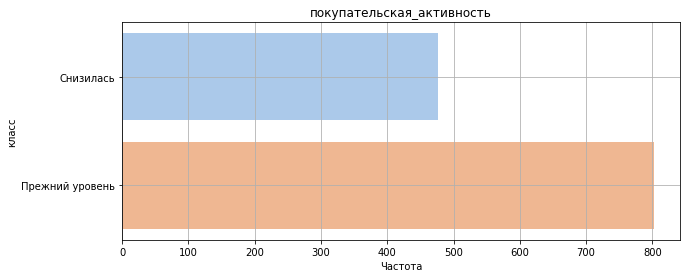

Прежний уровень    0.627543
Снизилась          0.372457
Name: покупательская_активность, dtype: float64

In [38]:
make_countplot(market_file, 'покупательская_активность', 'класс')
market_file['покупательская_активность'].value_counts(normalize=True)

Больше чем для половины пользователей покупательская активность осталась на прежнем уровне.  
Для почти 500 - снизилась.

#### тип_сервиса

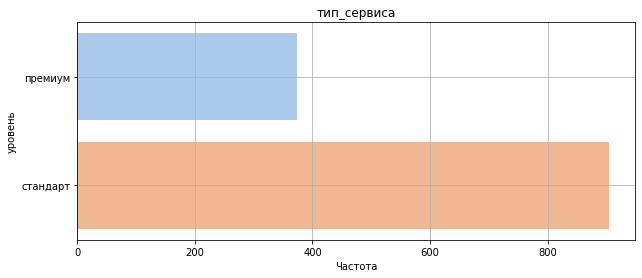

стандарт    0.707355
премиум     0.292645
Name: тип_сервиса, dtype: float64

In [39]:
make_countplot(market_file, 'тип_сервиса', 'уровень')
market_file['тип_сервиса'].value_counts(normalize=True)

Более половины клиентов пользуются уровнем "стандарт".  
Лишь треть - "Премиум".

#### разрешить сообщать 

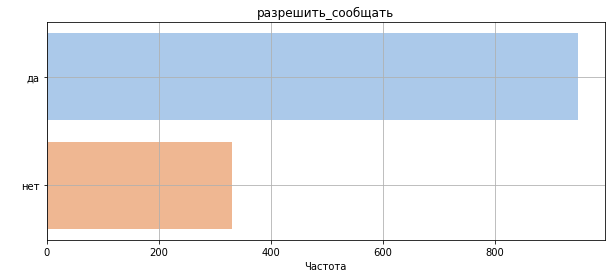

да     0.741784
нет    0.258216
Name: разрешить_сообщать, dtype: float64

In [40]:
make_countplot(market_file, 'разрешить_сообщать', ' ')
market_file['разрешить_сообщать'].value_counts(normalize=True)

Большая часть (3/4) пользователей дали согласие на то, чтобы получать дополнительные предложения о товаре.

#### маркет_актив_6мес

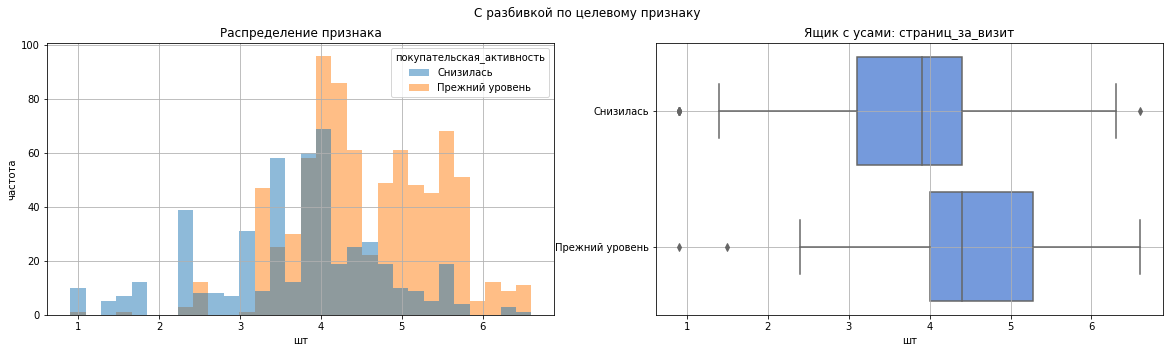

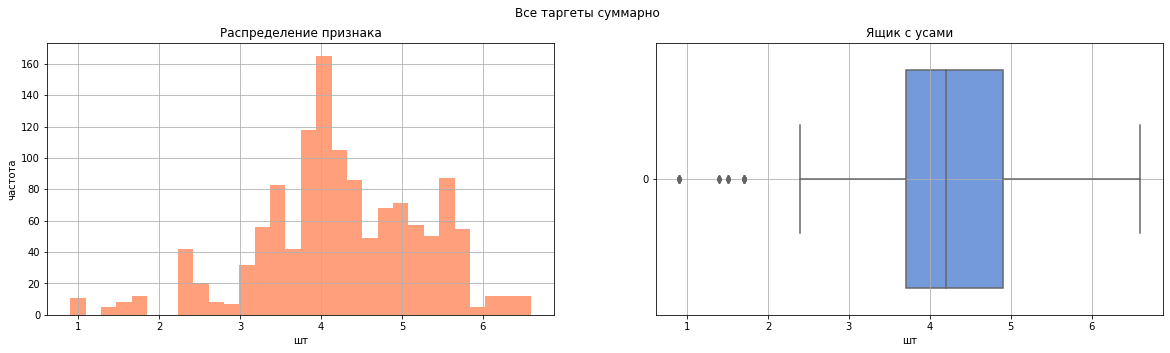

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1278.0,4.247966,1.018163,0.9,3.7,4.2,4.9,6.6


In [41]:
make_dif_hist(market_file, 'маркет_актив_6_мес', 30, 'шт')

Для категории "Снизилась" характерно небольшое смещение среднего и разброса влево.

Видно выбросы. Изучим подробнее датасет при значениях меньше 2.

In [42]:
market_file.query('маркет_актив_6_мес < 2').describe().T

,count,mean,std,min,25%,50%,75%,max
id,36.0,215604.388889,277.822480,215378.00,215449.2500,215541.50,215655.25,216638.00
маркет_актив_6_мес,36.0,1.369444,0.332797,0.90,0.9000,1.50,1.70,1.70
маркет_актив_тек_мес,36.0,3.972222,0.608798,3.00,4.0000,4.00,4.00,5.00
длительность,36.0,578.305556,205.278044,188.00,446.5000,590.00,735.00,932.00
акционные_покупки,36.0,0.568889,0.315747,0.21,0.3175,0.39,0.91,0.99
средний_просмотр_категорий_за_визит,36.0,2.333333,1.095445,1.00,2.0000,2.00,3.00,6.00
неоплаченные_продукты_штук_квартал,36.0,3.500000,2.131398,0.00,3.0000,3.00,5.00,9.00
ошибка_сервиса,36.0,4.333333,1.882248,1.00,3.0000,4.00,5.25,8.00
страниц_за_визит,36.0,4.500000,2.478479,1.00,3.0000,4.00,5.00,16.00


Таких значений 36.  
При этом видно, что зачастую они ниже, чем количество маркетинговых активностей по текущему месяцу.  

Проверим, есть ли еще такие ситуации в датасете.   
Выведем их количество на экран.

In [43]:
len(market_file.query('маркет_актив_6_мес < маркет_актив_тек_мес'))

481

Такое количество говорит о том, что текущий месяц не входит в статистику последнего полугодия.  

Также видим, что почти в половине случаев маркетинговых активностей было больше за последний месяц, чем до этого за полгода.  
Судя по всему, их количество резко увеличилось в последнее время.

Удалять данные не будем:
* Вполне вероятно, что ранее маркетинговых коммуникаций проводилось меньше, и для определенного вида клиентов рассылок было менее 2 в месяц.

Вывод по гистограмме и описательной статистике:  
* Нормальное распределение. 
* В среднем 4.2 коммуникации в месяц.
* Разброс от 0.9 до 6.6

#### маркет_актив_тек_мес

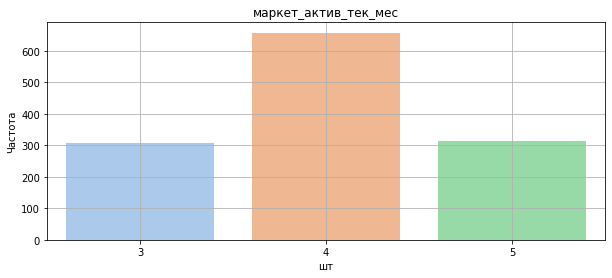

4    657
5    315
3    306
Name: маркет_актив_тек_мес, dtype: int64

In [44]:
make_countplot_x(market_file, 'маркет_актив_тек_мес', 'шт')

market_file['маркет_актив_тек_мес'].value_counts()

Всего три значения: 3/4/5 шт за текущий месяц.   
Мода - 4, в два раза больше любого другого значения.   
Значения 3 и 5 присутствуют в датасете примерно в одинаковом количестве.

В основном в текущем месяце на клиента приходится 4 маркетинговые коммуникации.

#### Длительность (дней с момента регистрации)

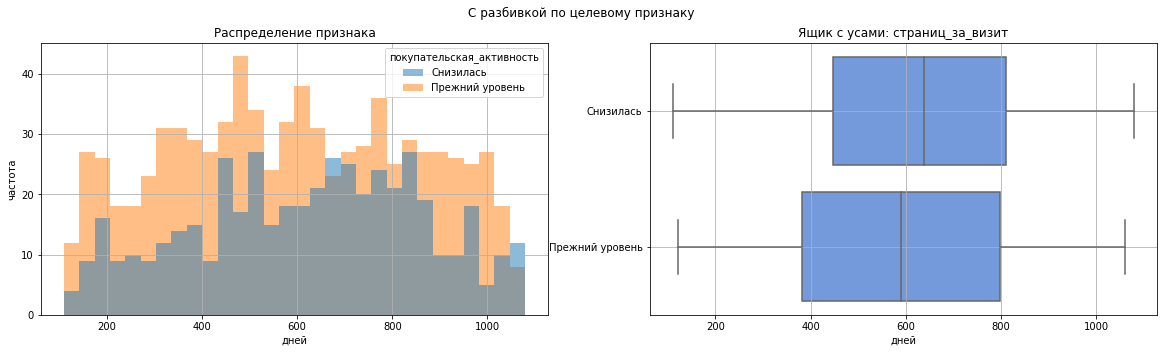

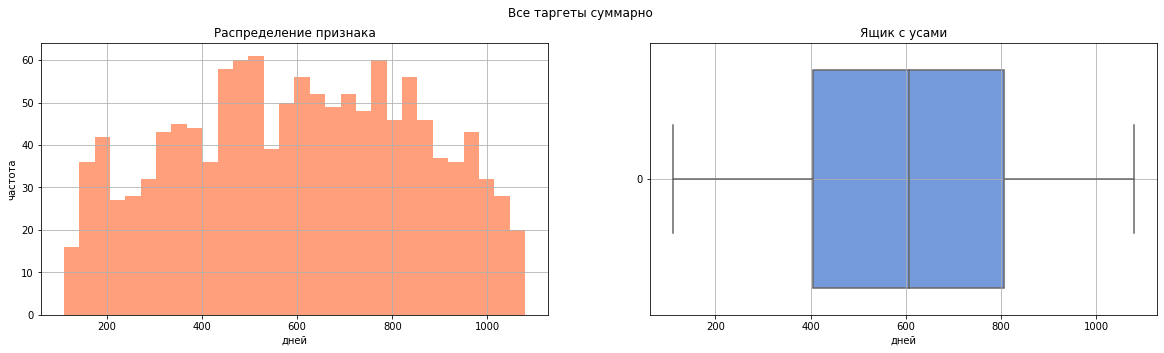

,count,mean,std,min,25%,50%,75%,max
длительность,1278.0,601.773083,249.992445,110.0,404.0,606.5,806.0,1079.0


In [45]:
make_dif_hist(market_file, 'длительность', 30, 'дней')

Выбросов не наблюдается:

* Данные распределены равномерно.
* Среднее - 601.8 дней, стандартное отклонение примерно 250.
* Разброс - от 110 до 1079 дней.


#### акционные покупки

Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев:

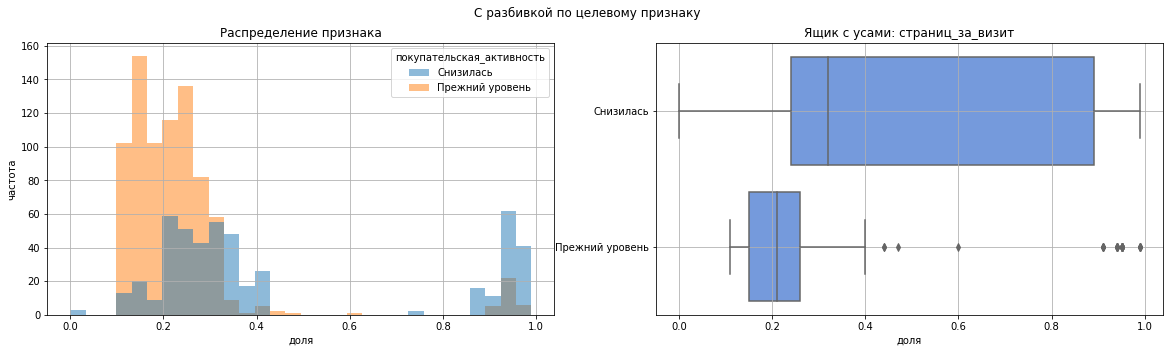

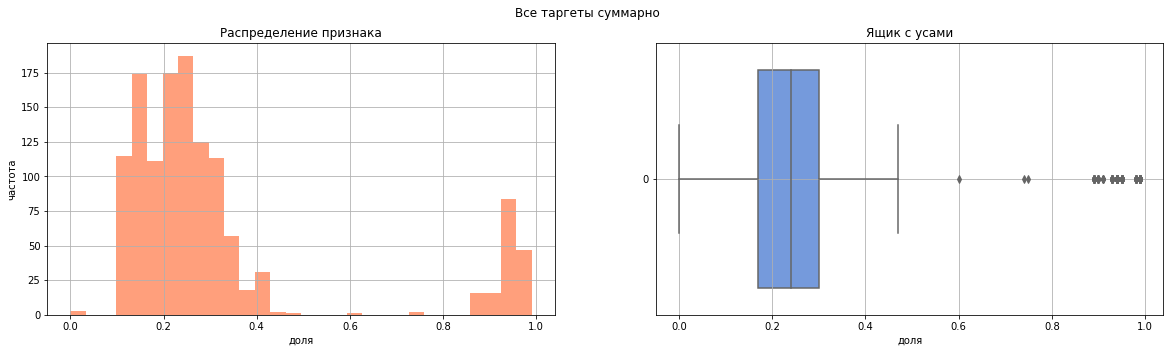

,count,mean,std,min,25%,50%,75%,max
акционные_покупки,1278.0,0.320509,0.250331,0.0,0.17,0.24,0.3,0.99


In [46]:
make_dif_hist(market_file, 'акционные_покупки', 30, 'доля')

Высокие доли покупок по акции характерны именно для пользователей, попадающих в категорию активности "снизилась".

На общем графике видно два пика.  
Стоит проверить значения свыше 0.5 и их количество.

In [47]:
market_file.query('акционные_покупки > 0.5').describe().T

,count,mean,std,min,25%,50%,75%,max
id,166.0,215752.602410,385.049479,215349.0,215480.250,215624.00,215839.50,216647.00
маркет_актив_6_мес,166.0,3.749398,1.073694,0.9,3.225,4.00,4.40,5.70
маркет_актив_тек_мес,166.0,3.963855,0.695366,3.0,3.000,4.00,4.00,5.00
длительность,166.0,598.397590,237.480612,147.0,433.750,601.50,793.25,1064.00
акционные_покупки,166.0,0.940663,0.046725,0.6,0.930,0.94,0.98,0.99
средний_просмотр_категорий_за_визит,166.0,2.813253,1.300841,1.0,2.000,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,166.0,3.644578,2.481483,0.0,2.000,3.00,5.00,10.00
ошибка_сервиса,166.0,4.084337,1.783458,0.0,3.000,4.00,5.00,8.00
страниц_за_визит,166.0,5.680723,3.245583,1.0,3.000,5.00,7.00,15.00


Большое количество таких строк: 166.  
Закономерностей и связей с другими признаками не наблюдается.

Нет причин считать эти значения выбросами. Оставляем.

Выводы по гистограмме и описательной статистике:  
* Разброс среднемесячной доли покупок по акциям в месяц - от 0 до 0.99.
* В среднем - 0.32
* Для половины покупателей эта доля составляет от 0.17 до 0.3	.


Можно сказать, что клиенты с долей покупок по акциям свыше 0.5 - преимущественно пользующиеся сервисом для покупок по выгодным ценам.

#### Популярные категории

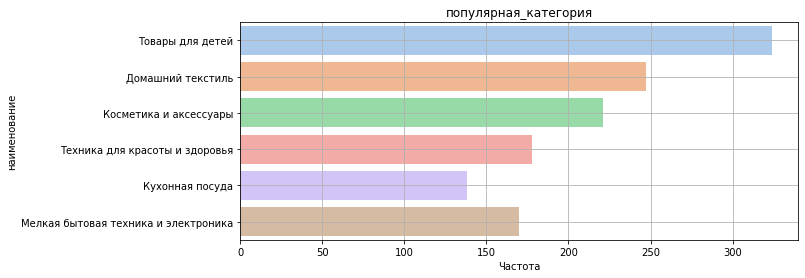

,Товары для детей,Домашний текстиль,Косметика и аксессуары,Техника для красоты и здоровья,Мелкая бытовая техника и электроника,Кухонная посуда
популярная_категория,324,247,221,178,170,138


In [48]:
make_countplot(market_file, 'популярная_категория', 'наименование')
market_file['популярная_категория'].value_counts().to_frame().T

Наиболее часто встречаемая популярная категория:
* Товары для детей

Самая редко встречаемая:
* Кухонная посуда

#### Средний просмотр категорий за визит

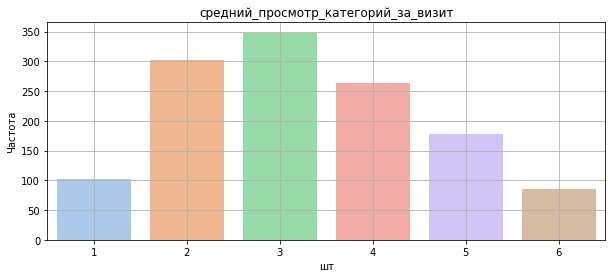

,3,2,4,5,1,6
средний_просмотр_категорий_за_визит,348,302,263,177,102,86


In [49]:
make_countplot_x(market_file, 'средний_просмотр_категорий_за_визит', 'шт')
market_file['средний_просмотр_категорий_за_визит'].value_counts().to_frame().T

От 1 до 6 категорий.

Самые часто встречаемые значения - 2,3,4.  
Мода - 3.


#### Неоплаченные продукты, штук, квартал

Общее число неоплаченных товаров в корзине за последние 3 месяца.

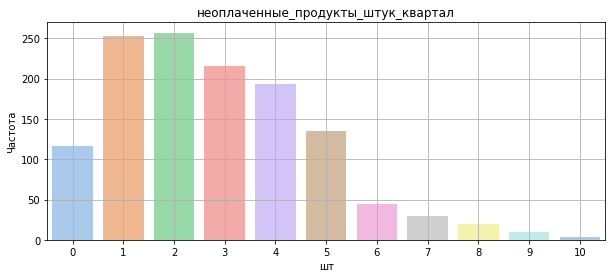

,count,mean,std,min,25%,50%,75%,max
неоплаченные_продукты_штук_квартал,1278.0,2.837246,1.967661,0.0,1.0,3.0,4.0,10.0


In [50]:
make_countplot_x(market_file, 'неоплаченные_продукты_штук_квартал', 'шт')

market_file['неоплаченные_продукты_штук_квартал'].describe().to_frame().T

Общее число неоплаченных товаров в корзине за последние 3 месяца составляет в половине случаев от 1 до 4 шт.

Разброс - от 0 до 10.
* Неоплаченные товары в количестве 6 и выше встречаются редко.

#### Ошибки сервиса

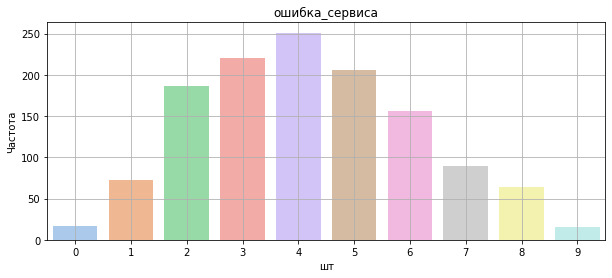

,count,mean,std,min,25%,50%,75%,max
ошибка_сервиса,1278.0,4.188576,1.955166,0.0,3.0,4.0,6.0,9.0


In [51]:
make_countplot_x(market_file, 'ошибка_сервиса', 'шт')

market_file['ошибка_сервиса'].describe().to_frame().T

Ошибки у клиентов встречались минимум 0, максимум 9 раз.

#### Страниц за визит

Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

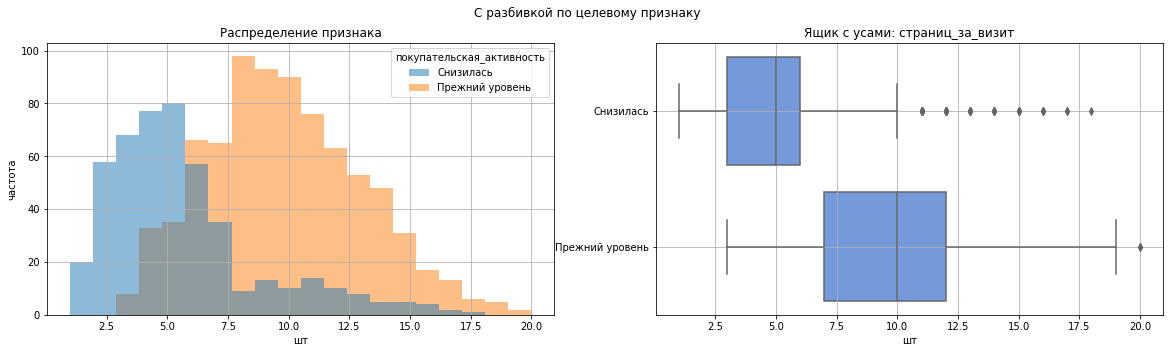

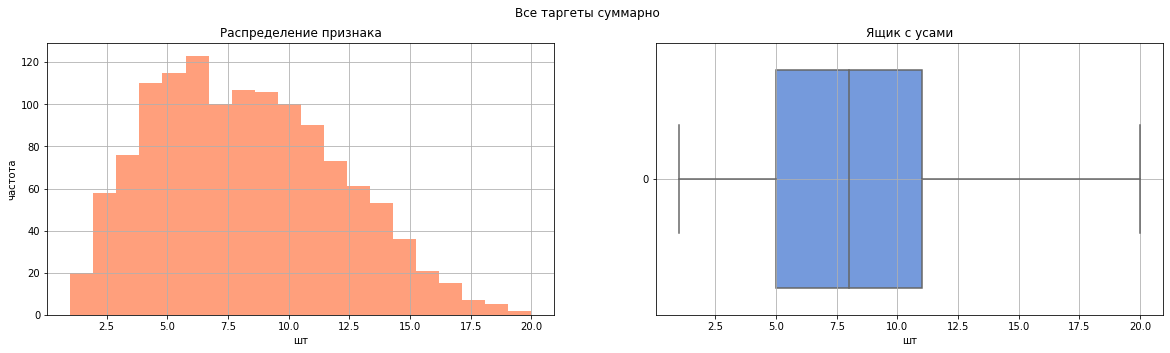

,count,mean,std,min,25%,50%,75%,max
страниц_за_визит,1278.0,8.153365,3.973083,1.0,5.0,8.0,11.0,20.0


In [52]:
make_dif_hist(market_file, 'страниц_за_визит', 20, 'шт')

Распределение близко к нормальному с небольшим смещением влево.

В среднем за один визит на сайт пользователи просматривают 8 страниц сайта.  
В половине случаев - от 5 до 11.   
Разброс от 1 до 20 страниц.

Нет значений, которые можно было бы считать выбросами.

Для пользователей с прежним уровнем активности характерна высокое количество просмотренных страниц за визит.

### market_money

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

**Период**

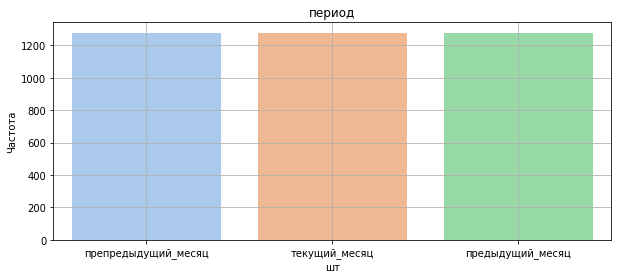

,предыдущий_месяц,текущий_месяц,препредыдущий_месяц
период,1278,1278,1278


In [53]:
make_countplot_x(market_money, 'период', 'шт')
market_money['период'].value_counts().to_frame().T

Информация о выручке имеется по трем периодам в равной степени - по 1278 записей, в соответствии с количеством строк датасета market_life.

**Выручка**

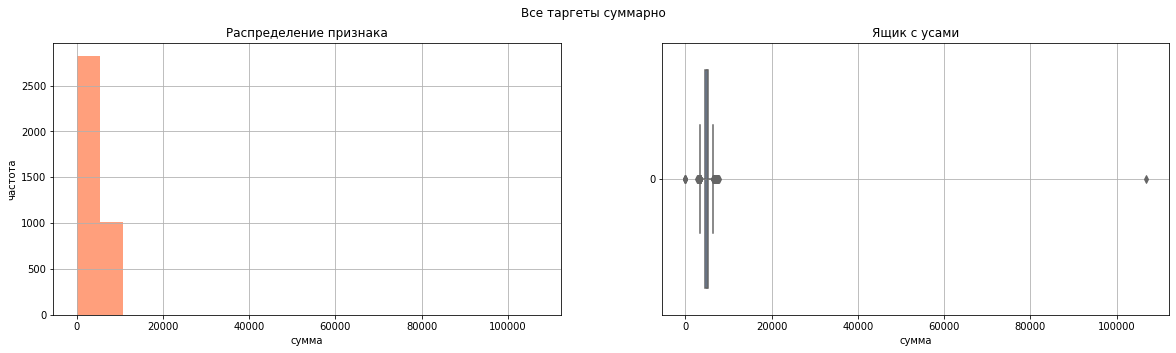

In [54]:
make_hist(market_money['выручка'], 20, 'сумма')

Видно очевидный выброс.

Проверим значения свыше 20000:

In [55]:
market_money.query('выручка>20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


Имеется одна запись с явно завышенной выручкой - 106862.2.

Проверим записи по остальным периодам этого клиента:

In [56]:
market_money.query('id==215380')

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


* Явная ошибка в подсчете выручки этого месяца.

Если просто удалить выброс, придется в дальнейшем удалять всю информацию по этому пользователю.  
Попробуем заменить на среднее значение.

**Можно заменить выброс на значение предыдущего месяца, умноженного на некий коэффициент.**  
Найдем его:
* Посмотрим, во сколько раз отличается выручка текущего месяца от предыдущего для пользователей со значением `предыдущий_месяц` >6000

In [57]:
# Объединим для каждого пользователя данные по разным периодам в одну строку:
helper = market_money.query('id!=215380 and выручка!=0').pivot_table(index='id', columns='период', values='выручка')

# Посмотрим, какие встречаются отношения: 'выручка текущий месяц' / 'выручка предыдущий месяц'
(helper.query('предыдущий_месяц >= 6000')['текущий_месяц'] / helper.query('предыдущий_месяц >= 6000')['предыдущий_месяц']).describe()

count    73.000000
mean      1.058924
std       0.109757
min       0.592141
25%       1.012921
50%       1.083172
75%       1.147435
max       1.201173
dtype: float64

В 75% случаев выручка текущего месяца выше предыдущего более чем на 1,3%.

Среднее значение - 1.059.  

**Заменим выброс для этого клиента на значение выручки предыдущего месяца, умноженного на 1.059:**

In [58]:
market_money.loc[(market_money['id']==215380) & (market_money['период']=='текущий_месяц'), 'выручка'] = 6077 * 1.059

# Проверяем, что значения для этого пользователя изменились:
market_money.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий_месяц,5051.000
97,215380,предыдущий_месяц,6077.000
98,215380,текущий_месяц,6435.543


Проверяем распределение признака после обновления таблицы:

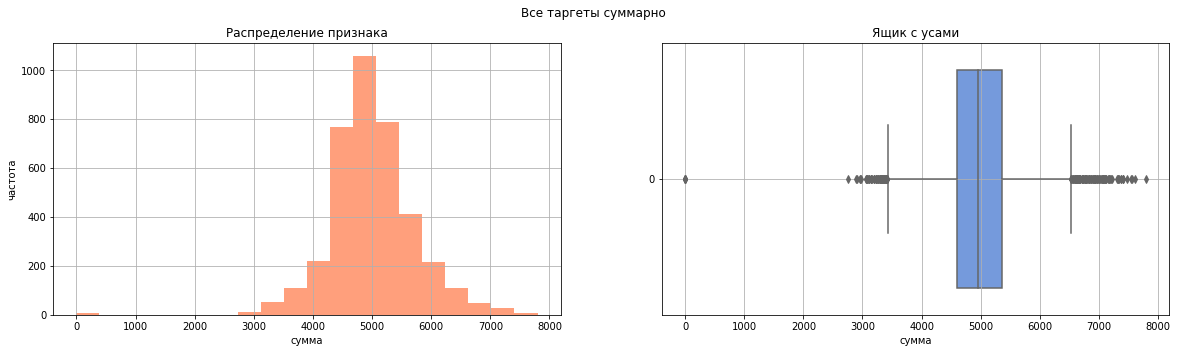

In [59]:
make_hist(market_money['выручка'], 20, 'сумма')

Изучим подробнее значения ниже 1000:

In [60]:
market_money.query('выручка<1000')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Посмотрим информацию для этих пользователей по другим периодам:

In [61]:
list_id = market_money.query('выручка<1000')['id']
market_money.query('id in @list_id')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


* Вероятно, это 3 новых пользователя, которые начали пользоваться платформой только в текущем месяце, из-за этого возникли нули.

**Поскольку для дальнейшей работы нам нужны только пользователи с покупательской активностью не менее 3 месяцев, удалим строки с клиентами из списка list_id.**

In [62]:
market_money = market_money.query('id not in @list_id')

# Проверяем, что длина датасета уменьшилась с 3833 до 3824
len(market_money)

3825

Посмотрим результат распределения после преобразований:

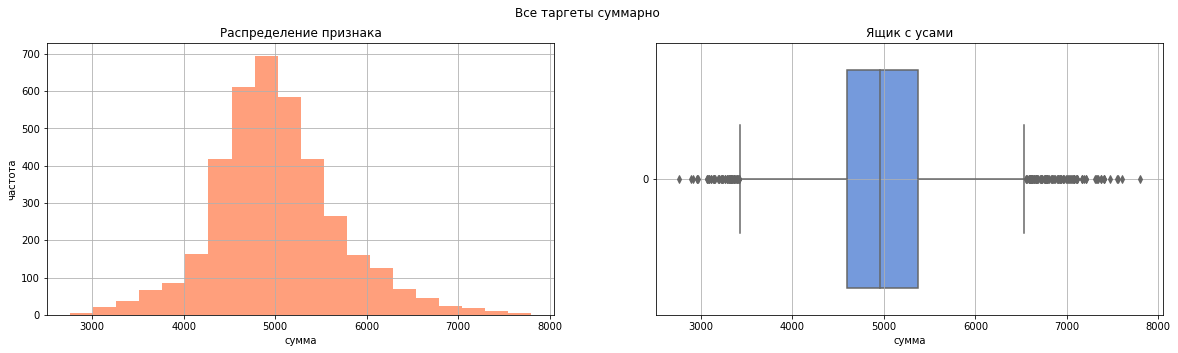

In [63]:
make_hist(market_money['выручка'].reset_index(drop=True), 20, 'сумма')

Распределение близко к нормальному.

Средняя выручка - 5010.5.  
Разброс - от 2758.7 до 7799.4.

Указанные на ящике с усами выбросы можно считать вполне обоснованными: в течение 3 месяцев некоторые пользователи могли делать как очень мало, так и очень много покупок.

Также посмотрим, как менялась общая выручка за последние 3 месяца:

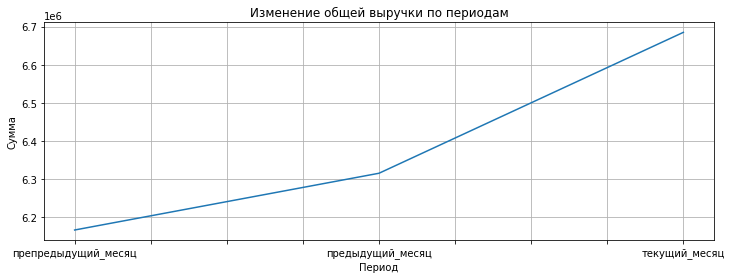

In [64]:
plt.figure(figsize=(12, 4))
market_money.groupby('период')['выручка'].sum().sort_values().plot()
plt.title('Изменение общей выручки по периодам')
plt.grid()
plt.xlabel('Период')
plt.ylabel('Сумма')
plt.show()

* Виден заметный постепенный рост.   
За 2 месяца на 515803.5 (на 8%)

Разобьем данные выручки по периодам и сравним:


препредыдущий_месяц: 


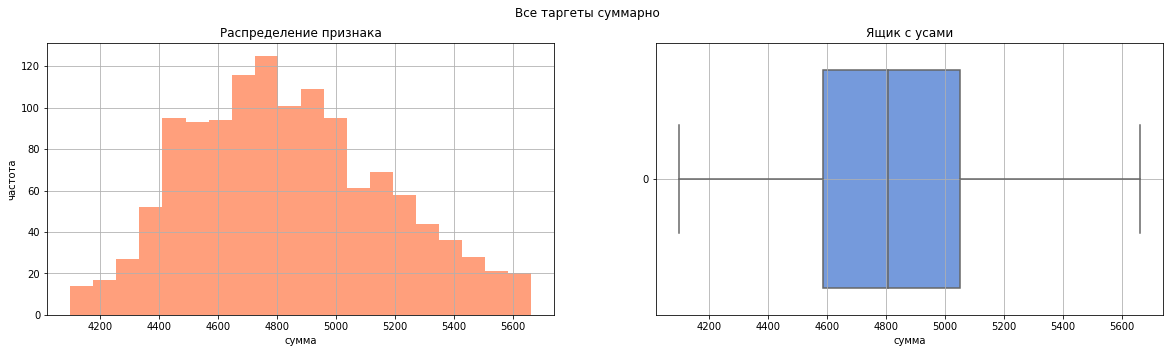


текущий_месяц: 


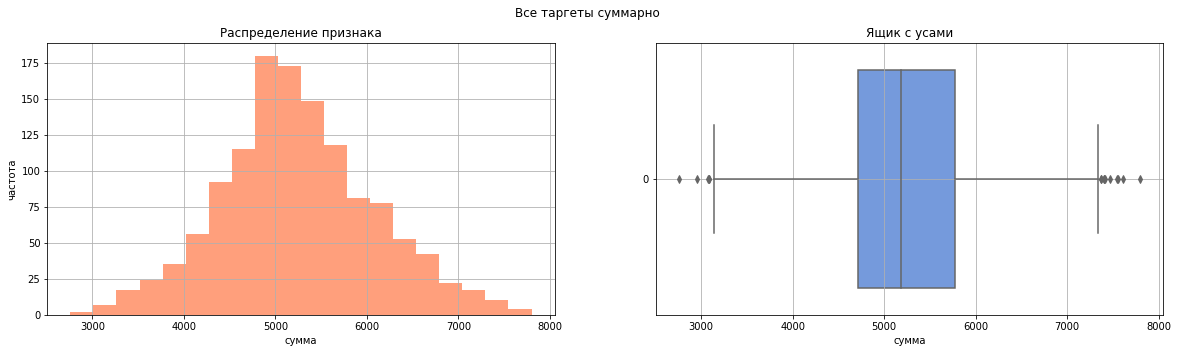


предыдущий_месяц: 


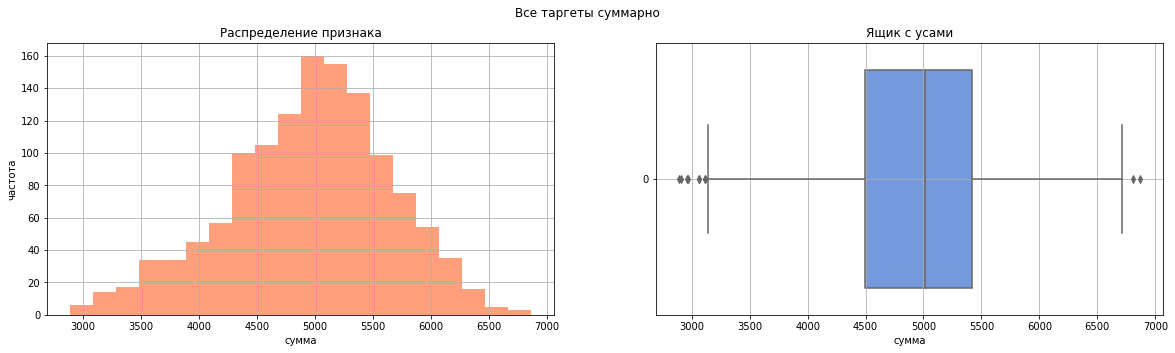

,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предыдущий_месяц,1275.0,4953.136863,700.145624,2890.0,4497.0,5009.5,5417.75,6869.5
препредыдущий_месяц,1275.0,4836.378824,333.217597,4098.0,4587.5,4809.0,5053.00,5663.0
текущий_месяц,1275.0,5243.018387,838.239433,2758.7,4712.0,5183.0,5770.50,7799.4


In [65]:
for i in market_money['период'].unique():
    print (f'\n{i}: ')
    make_hist(market_money.loc[market_money['период']==i, 'выручка'].reset_index(drop=True), 20, 'сумма')

market_money_desc = pd.DataFrame(market_money.groupby('период')['выручка'].describe())

display(market_money_desc)

Видим, что: 
- Выручка стала распределена близко к нормальному в текущем месяце в сравнении с препредыдущим
- Среднее выручки росло с каждым месяцев
- При этом растет и разброс.
- 25 и 75 квартили также показывали бОльшие значения с каждым новым периодом

Тенденция:
- Рост средней выручки, разброса (мин/макс значений)

И визуально среднее графика смещается в правую сторону.

### market_time

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

**Период**

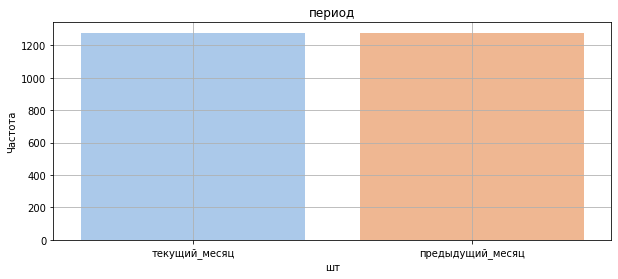

,предыдущий_месяц,текущий_месяц
период,1278,1278


In [66]:
make_countplot_x(market_time, 'период', 'шт')
market_time['период'].value_counts().to_frame().T

Значения времени, проведенного на сайте, в таблице распределено равномерно на текущий и предыдущий месяцы.

Количество строк по каждому из месяцев совпадает с количеством строк датасета market_file:

In [67]:
len(market_file)

1278

**Минуты**

Построим графики с разбиением по периоду и по обобщенным данным:


текущий_месяц: 


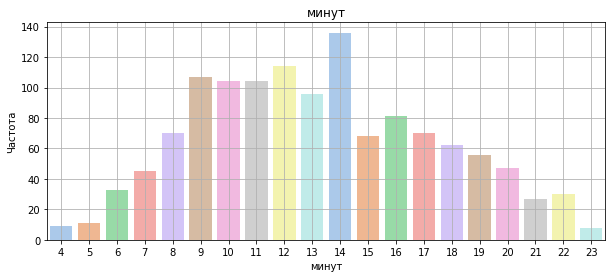

,count,mean,std,min,25%,50%,75%,max
минут,1278.0,13.198748,4.209799,4.0,10.0,13.0,16.0,23.0



предыдущий_месяц: 


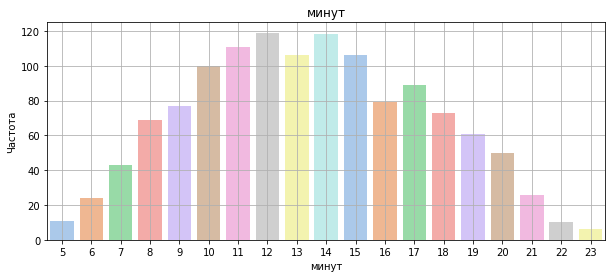

,count,mean,std,min,25%,50%,75%,max
минут,1278.0,13.43349,3.940617,5.0,10.0,13.0,16.0,23.0




Обобщенные данные:


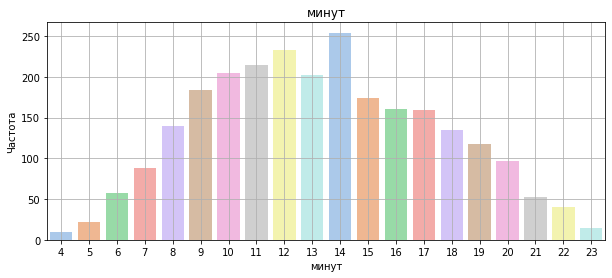

,count,mean,std,min,25%,50%,75%,max
минут,2556.0,13.316119,4.078322,4.0,10.0,13.0,16.0,23.0


In [68]:
for i in market_time['период'].unique():
    print(f'\n{i}: ')
    make_countplot_x(market_time.loc[market_time['период']==i], 'минут', 'минут')
    display(market_time.loc[market_time['период']==i, 'минут'].describe().to_frame().T)

print (f'\n\nОбобщенные данные:')
make_countplot_x(market_time, 'минут', 'минут')
market_time['минут'].describe().to_frame().T

Сильного падения количества минут в течение месяца не наблюдается, но оно есть.

Пользователи проводят на сайте в течение периода от 4 до 23 минут (месяцем ранее - от 5 до 23).

В среднем - 13.32.  

75% пользователей провели на сайте не менее 10 минут в течение каждого периода.


### money

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

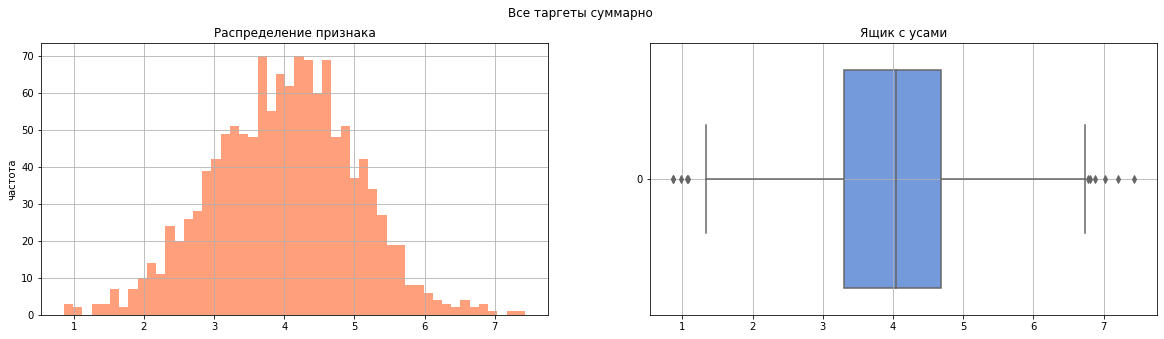

In [69]:
make_hist(money['прибыль'], 50, '')

Распределение прибыли близко к нормальному.

Среднее значение прибыли - около 4.  
Разброс от 0.86 до 7.43.

Явных выбросов нет.

### Выбор пользователей с с покупательской активностью не менее трёх месяцев

Пользователи с пользовательской активностью были выявлены в шаге 3.3 при изучении распределений выручки.  
Они сохранены в списке `list_id` - пользователи, которые не принесли выручки в прошлый и позапрошлый периоды.

Основываясь на этом списке, уберем не подходящих пользователей из наших датасетов (в market_money это уже сделали).

In [70]:
market_file = market_file.query('id not in @list_id')
market_time = market_time.query('id not in @list_id')
money = money.query('id not in @list_id')

Проверим, пропорциональны ли остались объемы датасетов:

In [71]:
print (len(market_file))
print (len(market_money))
print (len(market_time))
print (len(money))

1275
3825
2550
1275


Пропорции в объемах датасетов сохранены.

In [72]:
print ('Какая доля от изначального датасета осталась после преобразований: \n', round(1275/1300, 3))

Какая доля от изначального датасета осталась после преобразований: 
 0.981


* Сохранили более 98% данных.

### **Вывод по 3 разделу**

В результате исследовательского анализа данных было выявлено:

**Пользователи:**
* У 37% пользователей снизилась покупательская активность
* Лишь 26% пользуются премиум-подпиской сервиса
* Большая часть (3/4) пользователей дали согласие на то, чтобы получать дополнительные предложения о товаре.

Маркетинговые коммуникации:
* 3/4/5 шт за текущий месяц.
* В основном в текущем месяце на клиента приходится 4 маркетинговые коммуникации., в два раза больше любого другого значения.
* Предыдущие 6 месяцев среднее количество коммуникаций было примерно на таком же уровне, но с большим разбросом (от 0.9 до 6.6)

Дней с момента регистрации пользователей на сайте:
* Среднее - 601.9 дней.
* Разброс - от 110 до 1079 дней.

Среднемесячная доля покупок по акциям:
* Разброс - от 0 до 0.99.
* В среднем - 0.39
* Для половины покупателей эта доля составляет от 0.17 до 0.3 .
* Можно сказать, что клиенты с долей покупок по акциям свыше 0.5 - преимущественно пользующиеся сервисом для покупок по выгодным ценам.


Наиболее часто встречаемая популярная категория - *Товары для детей*
Самая редко встречаемая - *Кухонная посуда*


Общее число неоплаченных товаров в корзине за последние 3 месяца:
* в половине случаев от 1 до 4 шт.
* разброс - от 0 до 10.
* неоплаченные товары в количестве 6 и выше встречаются редко.

Ошибки сервиса:
* не более 9 среди всех пользователей в датасете

Просмотр страниц за один визит:
* В среднем 8 страниц
* В половине случаев - от 5 до 11.
* Разброс от 1 до 20


**Выручка:**
* исправлены выбросы (1 шт)
* найдены и удалены строки 3 пользователей, которые имели значение 0 по выручке хотя бы в одном из периодов
* значения представлены в равном количестве для текущего, предыдущего и препредыдущего периодов.
* значения показывают планомерные рост в последние 3 месяца (на 8% за 2 месяца)


**Время на сайте:**
* Пользователи проводили на сайте в течение периода от 4 до 23 минут.
* В среднем - 13.34.
* 75% пользователей провели на сайте не менее 10 минут в течение периода.

**Прибыль:**
* Все пользователи принесли прибыль за выбранный период (3 мес)
* Среднее значение прибыли - около 4.
* Разброс от 0.86 до 7.43.

**Отбор пользователей:**
* из датасетов убраны 3 пользователя с покупательской активностью менее трёх месяцев

## **Объединение таблиц**

Объединим таблицы market_file.csv, market_money.csv, market_time.csv

Перед объединением с "market_file" необходимо привести таблицы "market_money" и "market_time" к подходящему виду:
* сгруппировать данные по разным периодам в одну строку для каждого `id`


In [73]:
# Создаем сводную таблицу по market_money: 
## индекс - id, колонки - период, значения - выручки
market_money_new = market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()

# Задаем правильную последовательность столбцов, переименовываем
market_money_new = market_money_new[['id', 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']]
market_money_new.columns = ['id', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']

# Выводим на экран часть таблицы, проверяем размерность
display(market_money_new.head(), market_money_new.shape)

# То же для market_time: 
market_time_new = market_time.pivot_table(index='id', columns='период', values='минут').reset_index()
market_time_new.columns = ['id', 'минут_предыдущий', 'минут_текущий']
display(market_time_new.head(), market_time_new.shape)

,id,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
0,215349,4472.0,5216.0,4971.6
1,215350,4826.0,5457.5,5058.4
2,215351,4793.0,6158.0,6610.4
3,215352,4594.0,5807.5,5872.5
4,215353,5124.0,4738.5,5388.5


(1275, 4)

,id,минут_предыдущий,минут_текущий
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


(1275, 3)

* Данные в таблицах распределены корректно
* Имеем верную размерность датафреймов для объединения с "market_file"

Объединение:

In [74]:
data_full = market_file.merge(market_money_new, on='id')
data_full = data_full.merge(market_time_new, on='id')

display(data_full.head())
data_full.shape

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


(1275, 18)

* Данные распределены корректно.
* Размерность верная.

In [75]:
data_full.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_препредыдущий                  0
выручка_предыдущий                     0
выручка_текущий                        0
минут_предыдущий                       0
минут_текущий                          0
dtype: int64

 * Пропусков нет

### Вывод по 4 разделу

Данные из таблиц market_money, market_file и market_time объединены.

Имеем таблицу из 1275 строк и 18 столбцов.

## **Корреляционный анализ**

Уберем столбец `id`, сделав его индексом:

In [76]:
data_full = data_full.set_index('id')

**Строим матрицу корреляций, визуализируем через heatmap:**

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий']


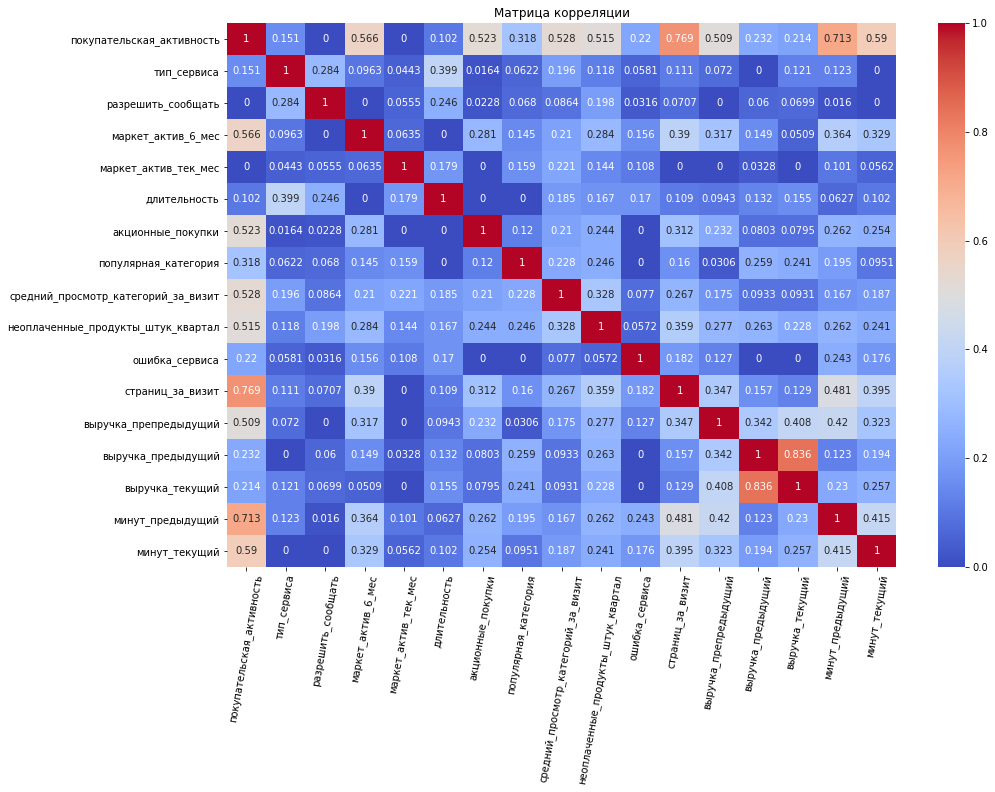

In [77]:
figsize = (8,8)

fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции')
sns.heatmap(data_full.phik_matrix(), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

**Целевой признак:**
* Покупательская активность

**Признаки с высокой корреляцией:**
* 0.769 - Страниц за визит
* 0.713 - Минуты, проведённые на сайте за прошлый период

**Признаки со средней корреляцией:**
* 0.59 - Минуты, проведённые на сайте за текущий период
* 0.57 - Среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев
* 0.53 - Средний просмотр категорий за визит
* 0.52 - Акционные покупки
* 0.52 - Общее число неоплаченных товаров в корзине за последние 3 месяца
* 0.51 - Выручка за препредыдущий месяц


**Мультиколлинеарность не наблюдается.**  
Ожидаемо сильная корреляция есть только у признаков выручки предыдущего и текущего месяца - 0.836.

Построим две отдельные матрицы корреляции для сохраняющих и снижающих активность покупателей:


Покупательская активность: Снизилась
interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


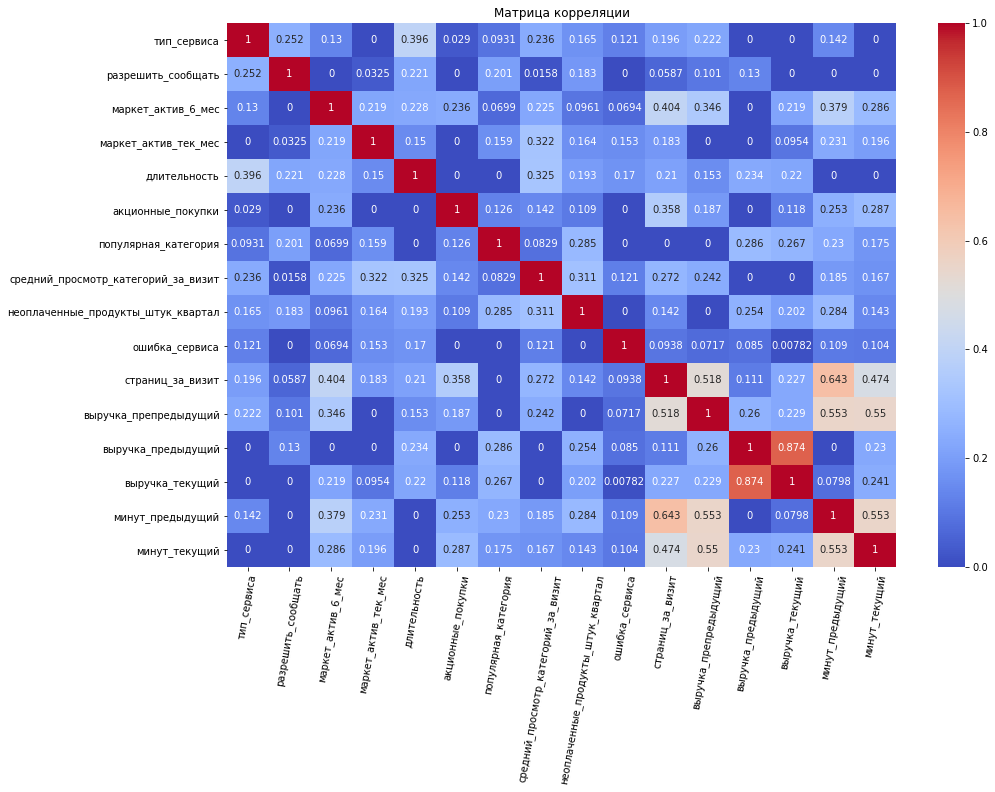


Покупательская активность: Прежний уровень
interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


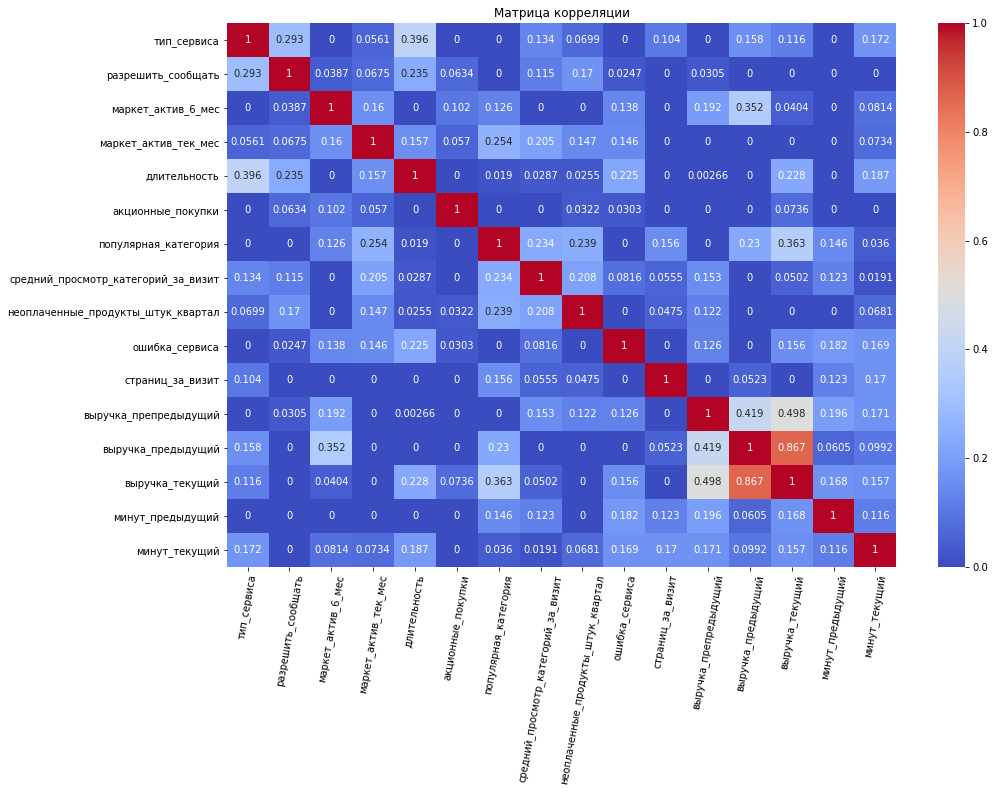

In [79]:
for i in data_full['покупательская_активность'].unique():
    print (f'\nПокупательская активность: {i}')
    figsize = (8,8)
    fig, ax = plt.subplots(figsize=(15,10))
    plt.title('Матрица корреляции')
    sns.heatmap(
        data_full.loc[data_full['покупательская_активность'] == i].phik_matrix(), 
        ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
    plt.xticks(rotation=80)
    plt.show()

Для пользователей с прежним уровнем активности особых изменений в корреляции не наблюдается.

Со сниженным уровнем:
* заметна корреляция `выручка_предыдущей` с `минут_предыдущий` и `минут_текущий`, а также `страниц_за_визит` с `минут_предыдущий`

**Построим диаграммы распределения** для некоторых признаков, имеющих высокую корреляцию с целевым, чтобы визуально оценить их влияние на покупательскую активность:

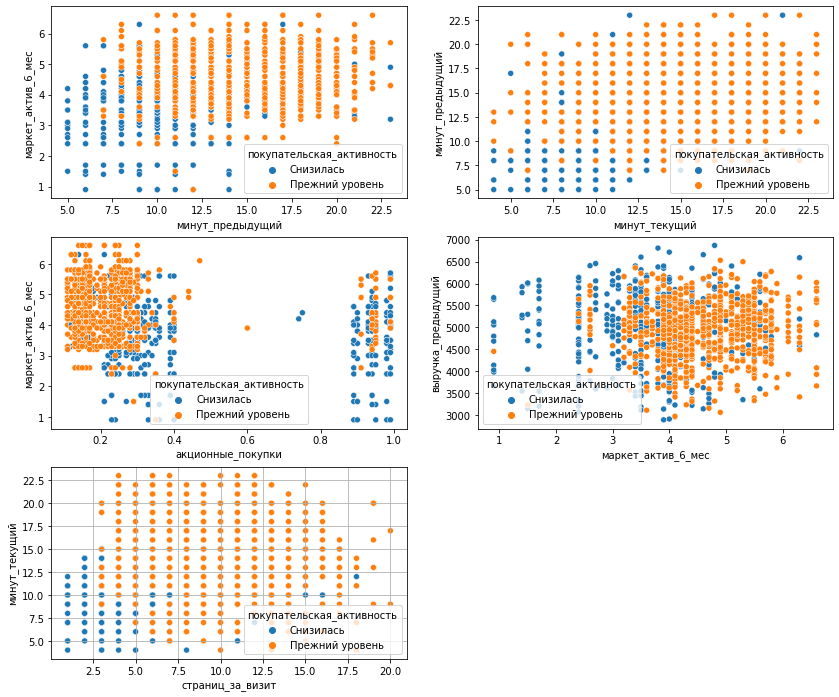

In [80]:
plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)
sns.scatterplot(data=data_full, y='маркет_актив_6_мес', x='минут_предыдущий', hue='покупательская_активность')

plt.subplot(3, 2, 2)
sns.scatterplot(data=data_full, y='минут_предыдущий', x='минут_текущий', hue='покупательская_активность')

plt.subplot(3, 2, 3)
sns.scatterplot(data=data_full, y='маркет_актив_6_мес', x='акционные_покупки', hue='покупательская_активность')

plt.subplot(3, 2, 4)
sns.scatterplot(data=data_full, y='выручка_предыдущий', x='маркет_актив_6_мес', hue='покупательская_активность')

plt.subplot(3, 2, 5)
sns.scatterplot(data=data_full, y='минут_текущий', x='страниц_за_визит', hue='покупательская_активность')

plt.grid()
plt.show()

Из графиков видно, что снижение покупательской активности часто связано с низкими уровнями:
* посещаемых страниц за визит
* минут, проведенных на сайте, за текущий и предыдущий периоды
* количества маркетинговых коммуникаций за 6 месяцев

И с высоким уровнем:
* доли акционных покупок

Посмотрим на распределение по `id` аукционных покупок:

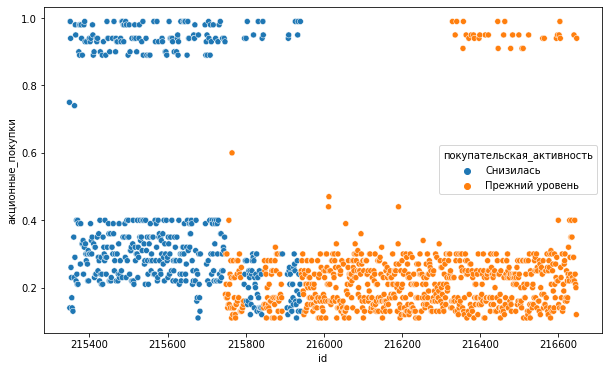

In [81]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_full, y='акционные_покупки', x='id', hue='покупательская_активность')
plt.show()

* Интересно, что у всех пользователей с `id` до 215700 снизилась активность, также они чаще совершают покупки по акциям

In [82]:
display (data_full.query('id<215700')[['маркет_актив_6_мес', 'маркет_актив_тек_мес']].describe().T)
display (data_full.query('id>215700')[['маркет_актив_6_мес', 'маркет_актив_тек_мес']].describe().T)

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,338.0,3.552071,1.006954,0.9,3.0,3.8,4.1,5.8
маркет_актив_тек_мес,338.0,3.967456,0.707405,3.0,3.0,4.0,4.0,5.0


,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,936.0,4.501389,0.899214,0.9,3.9,4.4,5.2,6.6
маркет_актив_тек_мес,936.0,4.018162,0.692736,3.0,4.0,4.0,4.0,5.0


Видно, что для них ниже среднее количество маркетинговых активностей за последние 6 месяцев, в среднем - на 1.


In [83]:
display (data_full.query('id<215700')['тип_сервиса'].value_counts(normalize=True))
display (data_full.query('id>215700')['тип_сервиса'].value_counts(normalize=True))

стандарт    0.630178
премиум     0.369822
Name: тип_сервиса, dtype: float64

стандарт    0.736111
премиум     0.263889
Name: тип_сервиса, dtype: float64

* При этом чаще, почти на 10 процентов, встречается тип сервиса премиум.

**В цифрах**

Наиболее заметные влияния признаков на целевой - распределение классов покупательской активности по долям:

1. Акционные покупки - выше 0.5

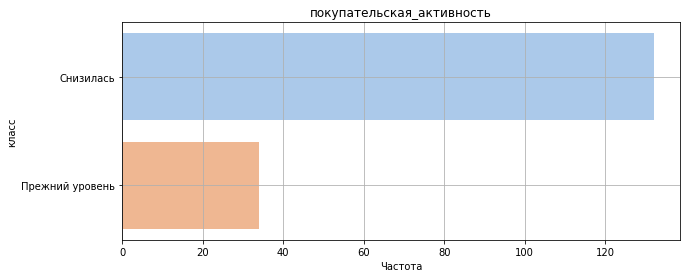

Снизилась          0.795
Прежний уровень    0.205
Name: покупательская_активность, dtype: float64

In [84]:
make_countplot(data_full.query('акционные_покупки > 0.5'), 'покупательская_активность', 'класс')
round(data_full.query('акционные_покупки > 0.5')['покупательская_активность'].value_counts(normalize=True), 3)

2. Маркетинговые коммуникации за 6 мес - менее 3.5 в среднем:

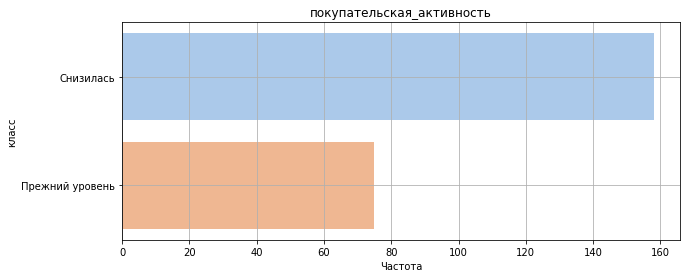

Снизилась          0.678
Прежний уровень    0.322
Name: покупательская_активность, dtype: float64

In [85]:
make_countplot(data_full.query('маркет_актив_6_мес < 3.5'), 'покупательская_активность', 'класс')
round(data_full.query('маркет_актив_6_мес < 3.5')['покупательская_активность'].value_counts(normalize=True), 3)

3. Просмотр низкого количества страниц за визит - 5 и менее:

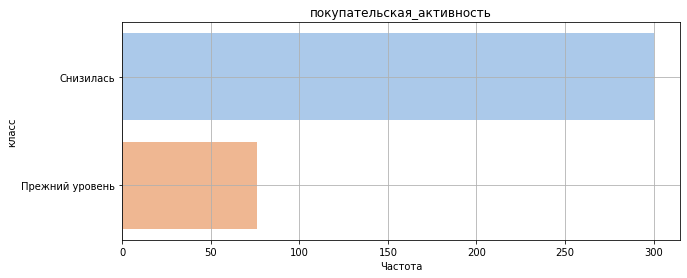

Снизилась          0.798
Прежний уровень    0.202
Name: покупательская_активность, dtype: float64

In [86]:
make_countplot(data_full.query('страниц_за_визит <= 5'), 'покупательская_активность', 'класс')
round(data_full.query('страниц_за_визит <= 5')['покупательская_активность'].value_counts(normalize=True), 3)

### Вывод по 5 разделу

Снижение покупательской активности часто связано с низкими уровнями:
* посещаемых страниц за визит
* минут, проведенных на сайте, за текущий и предыдущий периоды
* количества маркетинговых коммуникаций за 6 месяцев

И с высоким уровнем:
* доли акционных покупок

**Признаки с высокой корреляцией:**
* 0.769 - Страниц за визит
* 0.713 - Минуты, проведённые на сайте за прошлый период

**Признаки со средней корреляцией:**
* 0.59 - Минуты, проведённые на сайте за текущий период
* 0.57 - Среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев
* 0.53 - Средний просмотр категорий за визит
* 0.52 - Акционные покупки
* 0.52 - Общее число неоплаченных товаров в корзине за последние 3 месяца
* 0.51 - Выручка за препредыдущий месяц

## **Использование пайплайнов**

### Создание выборок

Делим датасет на датафреймы с входными и целевым признаками:

In [87]:
X = data_full.drop('покупательская_активность', axis=1)
y = data_full['покупательская_активность']
display(X.head(2), X.shape)
display(y.head(2), y.shape)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий
id,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13


(1275, 16)

id
215349    Снизилась
215350    Снизилась
Name: покупательская_активность, dtype: object

(1275,)

Разобьем выборку на обучающую и тестовую:

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Проверяем размерность
print (len(X_train), len(y_train), '\n', len(X_test), len(y_test))

956 956 
 319 319


Кодирование целевого признака:

Определим категорию "Прежний уровень" как 0, "Снизилась" - как 1.

In [89]:
original_classes = ['Прежний уровень', 'Снизилась']


le_custom = LabelEncoder()
le_custom.classes = np.array(original_classes)   
le_custom.classes

array(['Прежний уровень', 'Снизилась'], dtype='<U15')

In [90]:
y_train = le_custom.fit_transform(y_train)
y_test = le_custom.transform(y_test)

"Прежний уровень" закодирован как 0,   
"Снизилась - 1"

### Создание пайплайна для подготовки данных

Списки с названиями признаков:

In [92]:
ohe_columns = []
ord_columns = []
num_columns = []

for i in X_train.columns:
    if i=='разрешить_сообщать':
        ord_columns.append(i)
    elif X_train[i].dtype=='O':
        ohe_columns.append(i)
    else:
        num_columns.append(i)

print ('ohe_columns:\n', ohe_columns)
print ('\nord_columns:\n', ord_columns)
print ('\nnum_columns:\n', num_columns)

ohe_columns:
 ['тип_сервиса', 'популярная_категория']

ord_columns:
 ['разрешить_сообщать']

num_columns:
 ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий']


Пайплайны для подготовки признаков из списка ohe_columns и ord_columns:

In [93]:
ohe_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['нет', 'да']], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Объединение шагов подготовки:

In [94]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    ('ord', ord_pipe, ord_columns), 
    ('num', StandardScaler(), num_columns), 
], 
    remainder='passthrough'
)

Финальный пайплайн:

In [95]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]
)

### Применение пайплайна к данным

**Перебор гиперпараметров моделей**

In [96]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__max_features': range(2,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # для KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # для LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(0,40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    
    # для SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            kernel='poly'
        )],
        'models__degree': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

**Выбор метрики:**

Нам необходима общая оценка качества модели. 
Также нас есть некоторая неровнамерность в распределении значений целевого признака: записей о пользователях со сниженной активностью - меньше.  
В такой ситуации стоит подбирать лучшую модель по метрике ROC-AUC:  
  * Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.


Также нам в равной степени важно получать точный класс целевой переменной без уклона в высокий precision или recall - нужно наиболее полно определять снижение активности у клиентов и одновременно не отправлять излишнее количество персонализированных предложений и скидок пользователям, активность которых остается на прежнем уровне.  
Для этого также проверим значение f1:  
  * Она агрегирует значения precision и recall в единый показатель качества модели.   

**Запуск автоматического подбора способом RandomizedSearchCV:**

*(наивысшая скорость работы в сравнении с другими)*

In [97]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# Выведем на экран параметры лучшей модели и значение метрики
print ('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', randomized_search.best_score_)

print ('\n3 лучшие модели и их значения метрики:')
pd.DataFrame(randomized_search.cv_results_).sort_values(
    by='mean_test_score', ascending=False).head(3)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__degree,param_models,param_models__max_features,param_models__max_depth,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.107111,0.004487,0.011759,0.000293,passthrough,NaN,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,15.0,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.905017,0.901878,0.923474,0.909742,0.903991,0.908820,0.007766,1
8,0.110441,0.005502,0.011911,0.000333,passthrough,NaN,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,37.0,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.904900,0.901878,0.923826,0.909155,0.903873,0.908727,0.007916,2
9,0.020202,0.001186,0.014606,0.000939,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,NaN,8.0,"{'preprocessor__num': StandardScaler(), 'model...",0.877372,0.914965,0.928932,0.920070,0.889789,0.906226,0.019423,3


**Результат на кросс-валидационной выборке:**

Значение метрики ROC-AUC равна 0.909 - весьма неплохой результат. 

Лучшей оказалась следующая модель:  
* LogisticRegression(C=15, penalty='l1', random_state=42, solver='liblinear')
* Сила регуляризации - 15
* Скейлер не используется, 'passthrough'

Проверяем работу модели на тестовой выборке:

Метрика ROC-AUC на тестовой выборке:  0.917
Метрика F1-score на тестовой выборке:  0.879


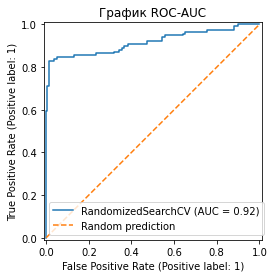

In [98]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print('Метрика ROC-AUC на тестовой выборке: ', round(roc_auc_score(y_test, y_test_proba[:,1]), 3))
print('Метрика F1-score на тестовой выборке: ', round(f1_score(y_test, y_test_pred), 3))

# Построим ROC-кривую для визуализации результата
RocCurveDisplay.from_estimator(randomized_search, X_test, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title('График ROC-AUC')
plt.legend()
plt.show()

**Результат, test:**

Получили хорошее значение AUC-ROC - тот же уровень, что и на тренировочных данных. Значит, модель работает качественно.  
Переобучения и недообучения не наблюдается.  
На ROC-кривой видно, что даже при минимальном (в пару процентов) FPR имеем очень высокое значение TPR - более 0.8.

Метрика F1-score показала хорошее значение среднего гармонического между precision и recall - почти 0.88. 
Кажется, в этом плане найден оптимальный баланс.

### **Вывод по 6 разделу**

Обучена модель для определения снижения пользовательской активности клиентов. 

Рассматривались, с перебором гиперпараметров, модели 4 методов:
* KNeighborsClassifier, DecisionTreeClassifier, SVC, LogisticRegression.

Метрика:
* ROC-AUC

**Результат:**

Лучшая модель:
* LogisticRegression(C=15, penalty='l1', random_state=42, solver='liblinear')
* Тип регуляризации - l1
* Сила регуляризации - 15

Результат roc_auc_score:
* 0.909 - Кросс-валидационные данные
* 0.917 - Тестовые данные

Дополнительно f1_score:
* 0.88 - Тестовые данные

## **Анализ важности признаков**

Интерпретируем модель методом оценки важности признаков SHAP.

Сначала подготовим данные: закодируем и масштабируем через preprocessor:

In [99]:
# Закодируем и масштабируем X_train через preprocessor:
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

# Возьмем названия столбцов через get_feature_names_out из ohe_pipe и ord_pipe:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Создаем DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed.head(3)

,ohe__тип_сервиса_стандарт,ohe__популярная_категория_Косметика и аксессуары,ohe__популярная_категория_Кухонная посуда,ohe__популярная_категория_Мелкая бытовая техника и электроника,ohe__популярная_категория_Техника для красоты и здоровья,ohe__популярная_категория_Товары для детей,ord__разрешить_сообщать,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__страниц_за_визит,num__выручка_препредыдущий,num__выручка_предыдущий,num__выручка_текущий,num__минут_предыдущий,num__минут_текущий
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.4,3.0,888.0,0.13,3.0,1.0,6.0,11.0,4821.0,4904.0,4800.0,15.0,12.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.8,3.0,616.0,0.16,3.0,2.0,2.0,11.0,5474.0,5305.0,5581.9,16.0,22.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.4,4.0,622.0,0.28,3.0,1.0,4.0,4.0,4418.0,5343.5,5772.5,11.0,9.0


Оценим общую важность признаков модели по значениям Шепли:

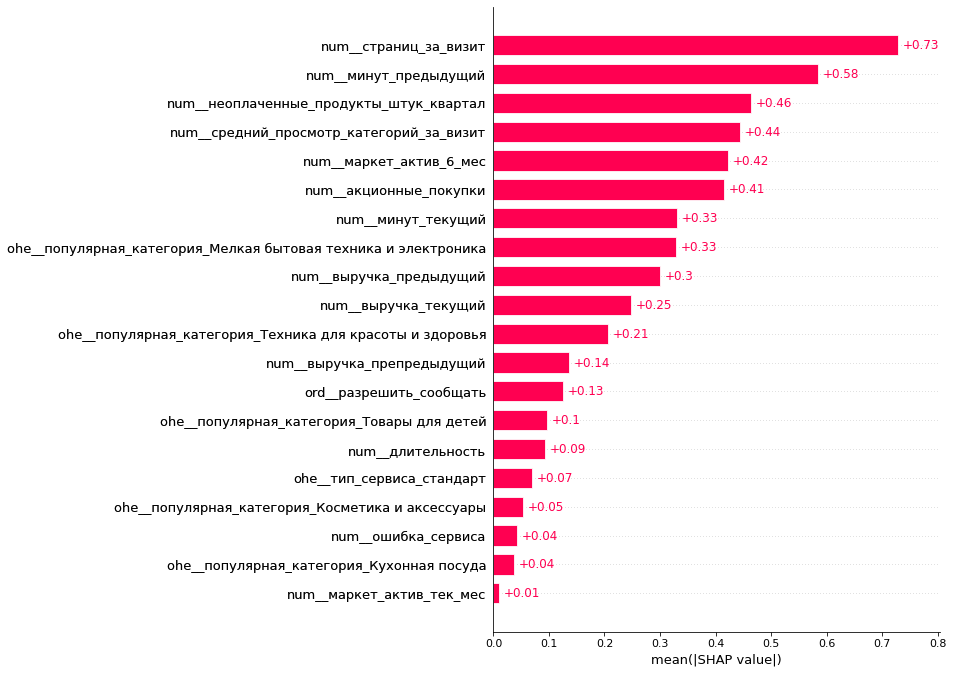

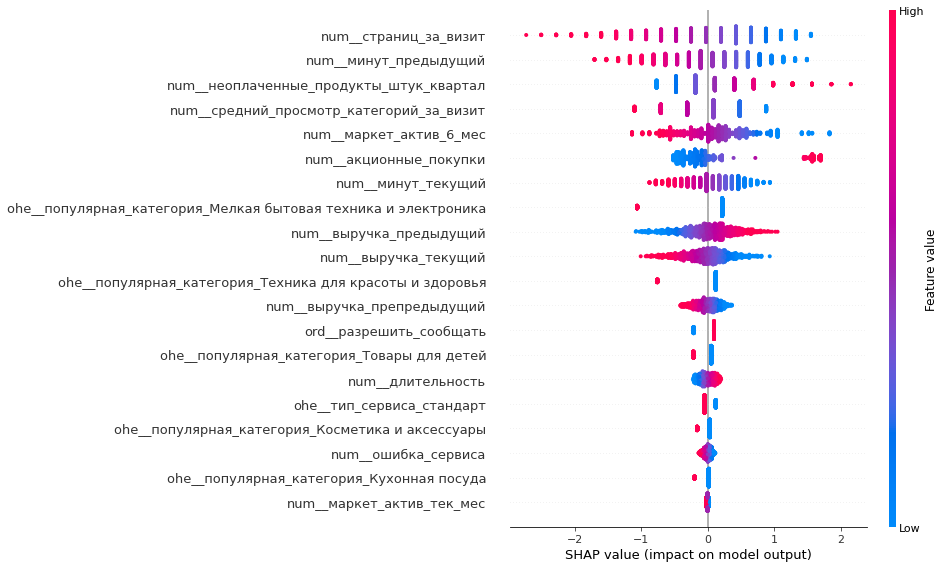

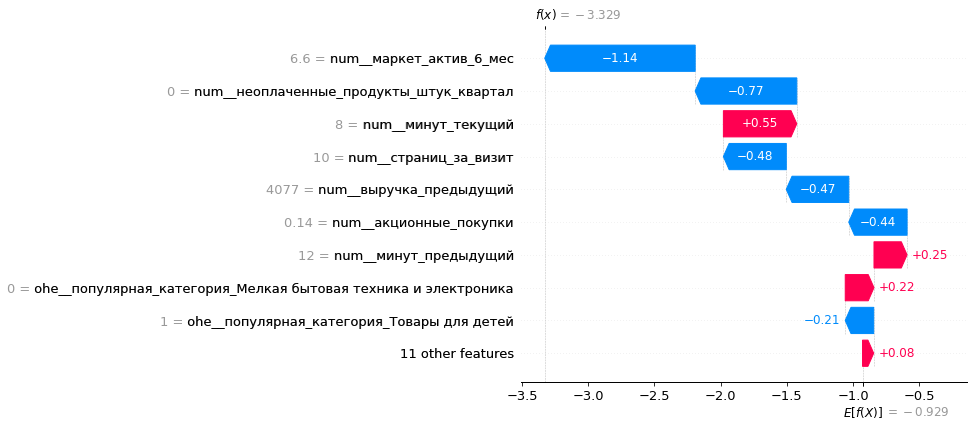

In [100]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_transformed)
shap_values = explainer(X_train_transformed)

shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)

# Для частного случая
shap.plots.waterfall(shap_values[10])

### Вывод

Наибольшее влияние, с точки зрения модели:
* `Страниц_за_визит`, `минут_предыдущий` - чем больше значения, тем ниже вероятность Снижения активности пользователя
* `Неоплаченные_продукты_квартал` - Чем больше, тем выше вероятность снижения активности пользователя

Умеренно:
* `средний_просмотр_категорий_за_визит`, `минут_текущий` - низкое значение повышает вероятность снижения активности

Интересная ситуация с `акционные_покупки`:
* Их влияние на целевой признак, в целом, не такое высокое. Но при этом есть порог, после которого при высоком значении акционных покупок сильно увеличивается вероятность снижения активности пользователя.   
Вероятно, это характеризует пользователей, совершающих покупки в сервисе преимущественно по акциям и скидкам.  
Для такой группы покупателей всегда будет высокий риск снижения покупательской активности при снижении количества акций и скидок в сервисе.

Также высокая вероятность снижения покупательской активности связана с низкими показателямя `маркетинг_актив_6_мес`.

`популярная_категория` 
1. Мелкая бытовая техника и электроника
2. Техника для красоты и здоровья

  * Примечательно, что у этих пользователей более устойчивая покупательская активность.

`выручка_предыдущий`:
* График показывает, в общем, простую логику: чем большую выручку принес пользователь в прошлом месяце, тем ниже вероятность, что в этом месяца этот показатель увеличится или останется на прежнем уровне.

`выручка_текущий`:
* Наоборот, чем выше выручка, тем ниже вероятность, что пользователь покажет спад покупательской активность.

**Наименее значимые признаки с точки зрения модели:**

* Тип сервиса (как премиум, так и стандарт)
* количество ошибок сервиса, 
* маркетинговые коммуникации в текущем месяце (вероятно, окажут влияние на последующие месяцы),
* длительность,
* разрешить сообщать,
* популярная категория, кроме мелкой бытовой техники и техники для красоты и здоровья

**Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:**

1. Стоит увеличивать вовлеченность пользователя, улучшать приложение и делать больше качественных рекомендаций, чтобы он просматривал больше страниц и проводил больше времени в сервисе - так должен уменьшиться отток покупателей.
2. Будет полезно при этом увеличить конверсию покупок из корзины. Скорее всего, надро обратить внимание на пользователей, которые редко покупают - добавляют в корзину, выходят из приложения и забывают о просмотренных страницах. 
3. Стоит подумать о пользователях с высокой долей акционных покупок: если эту долю снизить, в дальнейшем их покупательская активность будет в меньшей степени зависеть от количества акций и скидок.
4. Лучше не забывать про маркетинговые коммуникации.



## **Сегментация покупателей**

Сохраним список с 11 наиболее важными признаками в important_columns:

In [101]:
important_columns = ['id', 'популярная_категория','акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                     'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'выручка_предыдущий', 
                     'выручка_текущий', 'минут_предыдущий', 'минут_текущий', 'маркет_актив_6_мес']

### Сегментация покупателей

**Подготовка таблицы**

Вероятности для тестовых данных мы уже получили, они хранятся в y_test_proba.  
Найдем для тренировочных:

In [102]:
y_train_proba = randomized_search.predict_proba(X_train)
pd.DataFrame(y_train_proba).head(2)

,0,1
0,0.597696,0.402304
1,0.974165,0.025835


Добавим столбцы 1 (вероятность снижения активности) в таблицы X_train и X_test, объединим в data и добавим значения из money:

In [103]:
# Берем только признаки, показавшие на shap наибольшее влияние на целевой признак
X_test = X_test.reset_index()[important_columns]
X_test['вероятность_снижения'] = pd.DataFrame(y_test_proba)[1]

X_train = X_train.reset_index()[important_columns]
X_train['вероятность_снижения'] = pd.DataFrame(y_train_proba)[1]

# Объединим в одну таблицу data и добавим значения прибыли из таблицы money:
data = X_train.merge(X_test, how='outer')
data = data.merge(money, on='id')

**Добавим новый категориальный признак:** 
* риск снижения покупательской активности (высокий/средний/низкий).

In [104]:
data.loc[data['вероятность_снижения']>0.7 , 'риск_снижения'] = 'высокий'
data.loc[(data['вероятность_снижения']<=0.7) & (data['вероятность_снижения']>=0.3), 'риск_снижения'] = 'средний'
data.loc[data['вероятность_снижения']<0.3 , 'риск_снижения'] = 'низкий'

data.head()

,id,популярная_категория,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,страниц_за_визит,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий,маркет_актив_6_мес,вероятность_снижения,прибыль,риск_снижения
0,216614,Товары для детей,0.19,3,1,7,4835.0,4906.5,11,15,3.9,0.402304,5.49,средний
1,216082,Домашний текстиль,0.23,6,1,13,4224.0,3555.8,14,14,4.0,0.025835,4.37,низкий
2,216634,Техника для красоты и здоровья,0.40,3,4,7,2970.0,4289.5,14,13,4.1,0.298079,2.88,низкий
3,215734,Косметика и аксессуары,0.22,2,4,7,5141.0,5299.6,5,11,3.8,0.945814,4.87,высокий
4,215677,Домашний текстиль,0.24,2,3,11,4829.0,5211.2,17,16,4.6,0.197503,3.98,низкий


#### Изучение сегментов

Построим диаграммы рассеяния значений прибыли при разных признаках:

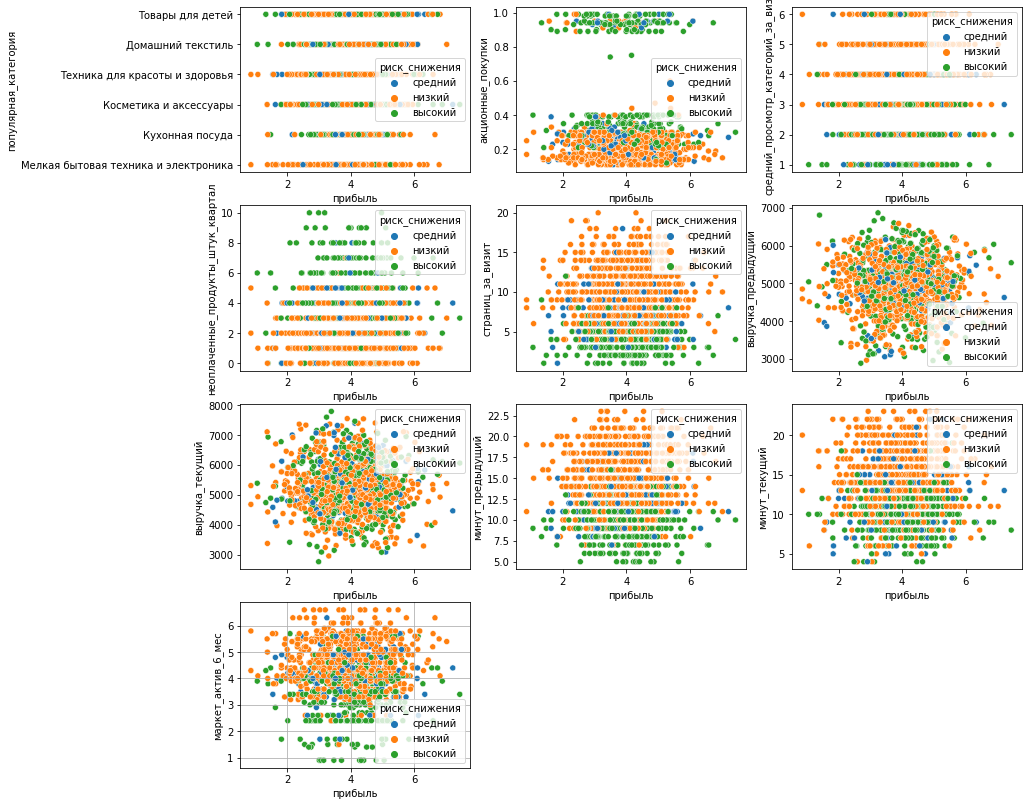

In [105]:
plt.figure(figsize=(14, 14))
p=1

for i in data.drop(['прибыль', 'вероятность_снижения', 'риск_снижения', 'id'], axis=1).columns:
    plt.subplot(4, 3, p)
    sns.scatterplot(data=data, y=i, x='прибыль', hue='риск_снижения')
    p += 1


plt.grid()
plt.show()

**Прибыль:**

Не наблюдается никаких корреляций и закономерностей с другими признаками.  


In [106]:
data.phik_matrix()['прибыль']

interval columns not set, guessing: ['id', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий', 'маркет_актив_6_мес', 'вероятность_снижения', 'прибыль']


id                                     0.106292
популярная_категория                   0.070138
акционные_покупки                      0.000000
средний_просмотр_категорий_за_визит    0.048737
неоплаченные_продукты_штук_квартал     0.000000
страниц_за_визит                       0.000000
выручка_предыдущий                     0.129636
выручка_текущий                        0.082954
минут_предыдущий                       0.000000
минут_текущий                          0.000000
маркет_актив_6_мес                     0.000000
вероятность_снижения                   0.000000
прибыль                                1.000000
риск_снижения                          0.000000
Name: прибыль, dtype: float64

* Максимальное значение корреляции - 0.13

**Сегменты покупателей**


#### Наименее устойчивые группы

Высока вероятность снижения покупательской активности (>70%)

Пользователи, у которых :
1. 3 и меньше  -  маркетинговых активностей за 6 месяцев в среднем
2. Менее 12.5 минут  -  время, проведенное на сайте за прошлый месяц (ниже 12.5 минут)
3. 5 и менее  -  просмотренных страниц за визит
4. 6 и более  -  неоплаченных продуктов в квартал, шт
5. 0.4 и более  -  доля акционных покупок

На диаграммах ниже для этих групп визуализируем процент пользователей, для которых риск снижения покупательской активности оценили как высокий:

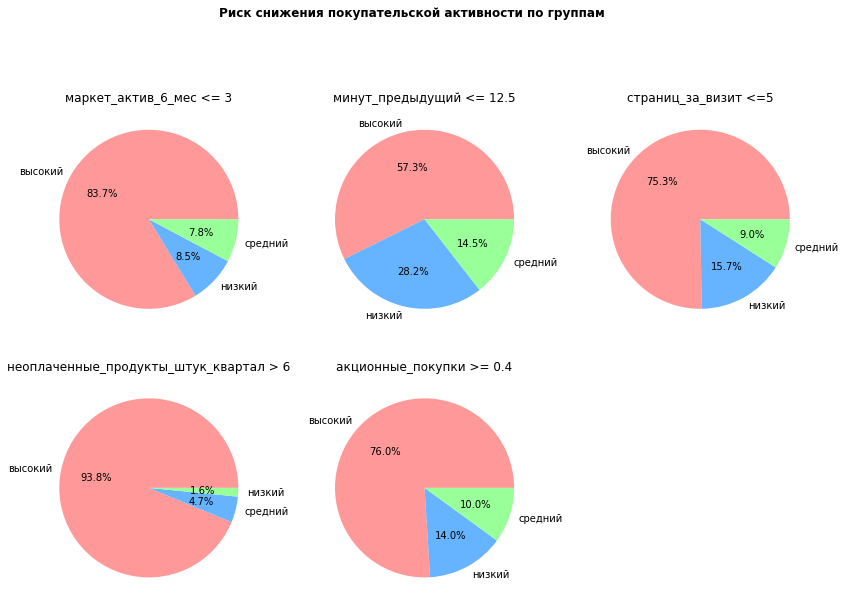

In [107]:
# функция построения диаграмм
def build_pie (helper, suptitle, colors):
    help_datas = []
    for i in helper:
        help_datas.append(data.query(i)['риск_снижения'].value_counts(normalize=True))
    plt.figure(figsize=(14, 14))
    p=1
    for df in help_datas:
        plt.subplot(3, 3, p)
        plt.pie(df, autopct='%1.1f%%', labels = df.index, colors=colors)
        plt.title(helper[p-1])
        p += 1
    plt.suptitle(suptitle, fontweight = 'bold')
    plt.show()

# Строим диаграммы для пользователей с плохими значениями ключевых признаков
helper = ['маркет_актив_6_мес <= 3', 'минут_предыдущий <= 12.5', 'страниц_за_визит <=5', 
          'неоплаченные_продукты_штук_квартал > 6', 'акционные_покупки >= 0.4']

build_pie (helper, 'Риск снижения покупательской активности по группам', ['#ff9999', '#66b3ff','#99ff99'])

Группы с самым большим процентов пользователей, склонных к снижению покупательской активности:
* Неоплаченные продукты более 6 штук 
* Маркетинговая активность 6 мес менее 3

#### Наиболее устойчивые группы

Низкая вероятность снижения покупательской активности (<30%)

* 0.2 и меньше  -  доля акционных покупок
* 3 и менее  -  неоплаченных продуктов квартал
* 10+  -  страниц за визит
* 5 и более  -  средний просмотр страниц за визит
* 15 и более  -  потраченных минут за текущий и предыдущий период
* 5 и более  -  маркетинговые коммуникации за 6 месяцев, шт/мес

На диаграммах ниже для этих групп - процент пользователей, для которых риск снижения покупательской активности оценили как низкий/средний/высокий:

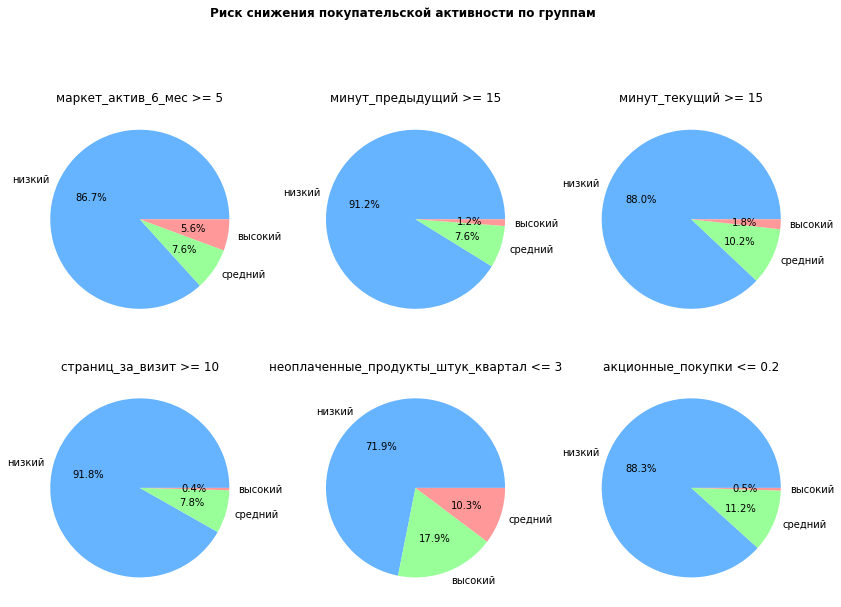

In [108]:
helper = ['маркет_актив_6_мес >= 5', 'минут_предыдущий >= 15', 'минут_текущий >= 15', 'страниц_за_визит >= 10', 
          'неоплаченные_продукты_штук_квартал <= 3', 'акционные_покупки <= 0.2']

build_pie(helper, 'Риск снижения покупательской активности по группам', ['#66b3ff', '#99ff99', '#ff9999'])

* Можно ориентироваться на эти цифры при разработке продукта, продумывании маркетинговых коммуникаций.

### Популярные категории

Сравним прибыли, которые встречаются среди разных категорий:

In [109]:
data.groupby('популярная_категория')['прибыль'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
популярная_категория,,,,,,,,
Косметика и аксессуары,221.0,4.080045,1.075508,1.37,3.4200,4.130,4.8500,7.43
Кухонная посуда,138.0,4.062609,0.898244,1.39,3.4250,4.105,4.6300,6.65
Товары для детей,323.0,4.027276,1.003191,1.33,3.3100,4.060,4.6600,6.81
Домашний текстиль,246.0,4.011179,0.938340,1.06,3.2975,4.020,4.6700,7.02
Мелкая бытовая техника и электроника,170.0,3.967882,1.021570,0.86,3.3400,4.000,4.6875,6.78
Техника для красоты и здоровья,177.0,3.804068,1.090758,0.86,3.0300,3.800,4.5600,6.59


Наибольший показатель средней прибыли у категории Косметика и аксессуары. Хотя остальные категории отстают не сильно.

Посмотрим, какие категории можно отнести к подверженным к снижению покупательской активности:

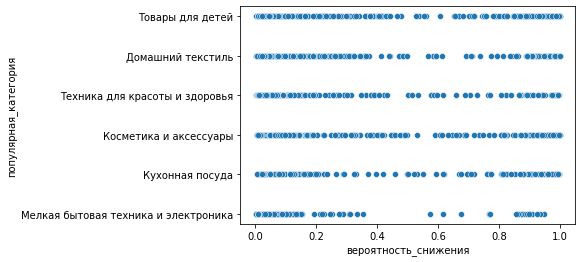

In [110]:
sns.scatterplot(data=data, x='вероятность_снижения', y='популярная_категория')
plt.show()

Отличается только категория "Мелкая бытовая техника и электроника". 

Пользователи этой группы более явно разделяются по риску снижения покупательской активности.

Посмотрим соотношение риска снижения покупательской активности для разных категорий:

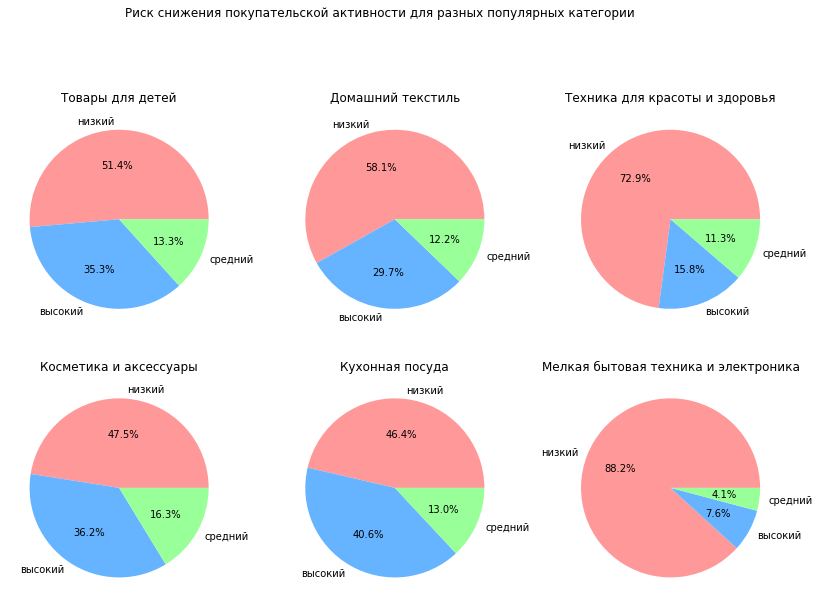

In [111]:
columns = data['популярная_категория'].unique().tolist()

plt.figure(figsize=(14, 14))
p=1
for i in columns:
    plt.subplot(3, 3, p)
    plt.pie(data.loc[data['популярная_категория']==i, 'риск_снижения'].value_counts(), autopct='%1.1f%%', labels = data.loc[data['популярная_категория']==i, 'риск_снижения'].value_counts().index, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title(i)
    p+=1
plt.suptitle('Риск снижения покупательской активности для разных популярных категории ')
plt.show()

Самые устойчивые: 
* Мелкая бытовая техника и электроника
* Техника для красоты и здоровья

Тем не менее, эти категории являются наименее популярными.  Также приносят наименьшую среднюю прибыль.

Самая же прибыльная категория - Косметика и аксессуары - в большей степени склонна к снижению покупательской активности.

**Проверим распределение значений весомых для снижения покупательской способности признаков в категории "Косметика и аксессуары".**

Вспомним, что со снижением активности обычно связаны следующие параметры:  
* маркет_актив_6_мес <= 3 
* минут_предыдущий <= 12.5 
* страниц_за_визит <=5 
* неоплаченные_продукты_штук_квартал > 6 
* акционные_покупки >= 0.4'

In [112]:
# Создадим переменную, в которой перечислим все признаки, которые часто приводят к уменьшению покупательской активности
help_list = 'маркет_актив_6_мес <= 3 or минут_предыдущий <= 12.5 or страниц_за_визит <=5 or неоплаченные_продукты_штук_квартал > 6 or акционные_покупки >= 0.4'

data_cat = data.query('популярная_категория=="Косметика и аксессуары"')

print ('Количество строк, в которых есть параметры, часто связанные с понижением покупательской активности: \n', 
       len(data_cat.query(help_list)))

print ('\nВсего строк категории "Косметика и аксессуары": \n', len(data_cat))

Количество строк, в которых есть параметры, часто связанные с понижением покупательской активности: 
 139

Всего строк категории "Косметика и аксессуары": 
 221


* Более чем в половине случаев выполняется условие, которое может привести к снижению покупательской активности.

Построим гистограммы распределения этих признаков для пользователей этой группы, для которых модель посчитала риск снижения активности как высокий:

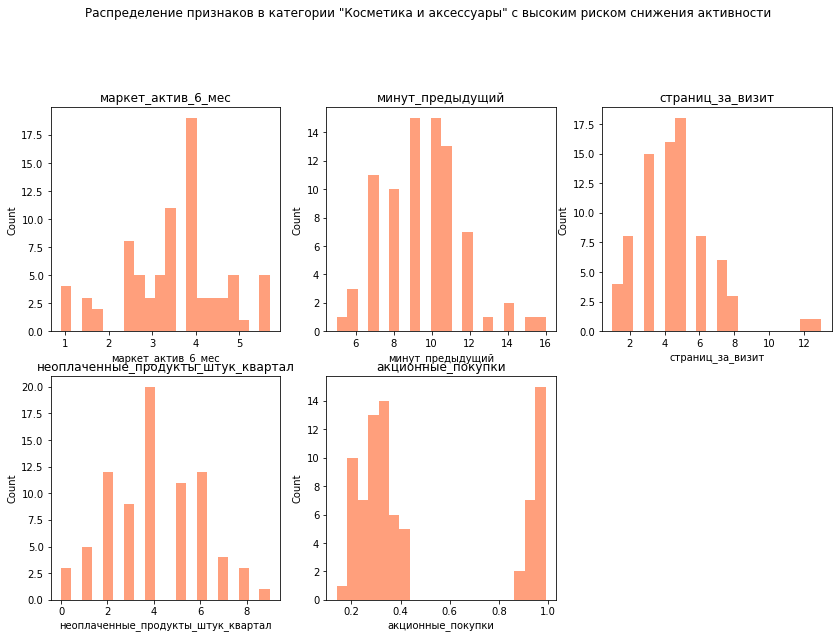

In [113]:
helper = ['маркет_актив_6_мес', 'минут_предыдущий', 'страниц_за_визит', 
          'неоплаченные_продукты_штук_квартал', 'акционные_покупки']

plt.figure(figsize=(14, 14))
p=1

for i in helper:
    plt.subplot(3, 3, p)
    sns.histplot(data=data.query('популярная_категория=="Косметика и аксессуары" and риск_снижения=="высокий"')[i], 
                 bins=20, color='coral', edgecolor=None)
    plt.title(i)
    p+=1
plt.suptitle('Распределение признаков в категории "Косметика и аксессуары" с высоким риском снижения активности')
plt.show()

**Вывод:**

Видно, что для клиентов, у которых снизилась активность, зачастую характерны все те же значения признаков, которые описывали ранее:

* маркет_актив_6_мес <= 3 
* минут_предыдущий <= 12.5 
* страниц_за_визит <=5 
* неоплаченные_продукты_штук_квартал > 6 
* акционные_покупки >= 0.4'

Что поможет удержать покупательскую активность клиента на прежнем уровне:
* Увеличение маркетинговых активностей 
* работа над вовлечением пользователя в сервис (например, больше качественных рекомендаций, чтобы он переходил по большему числу страниц)
* вовлечение в сервис пользователей, пользующихся им исключительно для покупок по скидкам/акциям


#### Пользователи с долей акционных_покупок более 0.8 в категории "Косметика и аксессуары"

Посмотрим, как можно снизить долю акционных покупок для пользователей, у которых этот показатель очень высокий.

Вернемся к матрице корреляции и посмотрим, с чем связан признак "акционные_покупки":

In [114]:
data.drop('id', axis=1).phik_matrix()['акционные_покупки'].sort_values()

interval columns not set, guessing: ['акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий', 'маркет_актив_6_мес', 'вероятность_снижения', 'прибыль']


прибыль                                0.000000
выручка_текущий                        0.079533
выручка_предыдущий                     0.080253
популярная_категория                   0.119945
средний_просмотр_категорий_за_визит    0.209745
неоплаченные_продукты_штук_квартал     0.244091
минут_текущий                          0.254443
минут_предыдущий                       0.261828
маркет_актив_6_мес                     0.281242
страниц_за_визит                       0.312313
вероятность_снижения                   0.457819
риск_снижения                          0.725994
акционные_покупки                      1.000000
Name: акционные_покупки, dtype: float64

Построим диаграммы рассеяния доли акционных покупок с 6 признаками, наиболее коррелирующими с  `акционные_покупки`:

interval columns not set, guessing: ['акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий', 'минут_текущий', 'маркет_актив_6_мес', 'вероятность_снижения', 'прибыль']


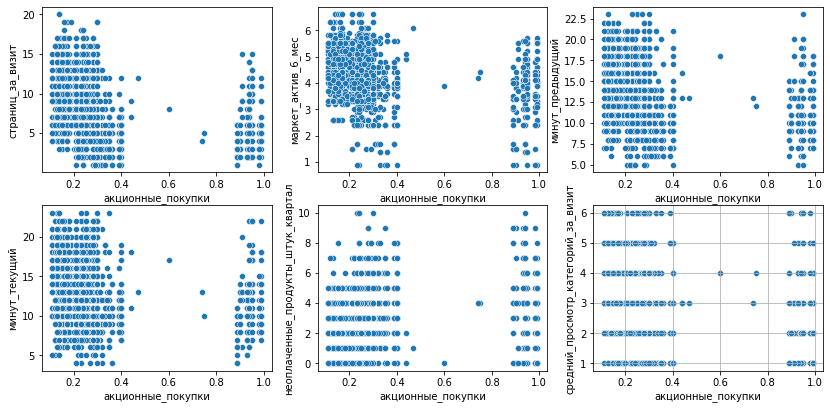

In [115]:
plt.figure(figsize=(14, 14))
p=1

for i in data.drop('id', axis=1).phik_matrix()['акционные_покупки'].sort_values(ascending=False).index[3:9]:
    plt.subplot(4, 3, p)
    sns.scatterplot(data=data, y=i, x='акционные_покупки')
    p += 1


plt.grid()
plt.show()

Видно, что пользователи с высокой долей акционных покупок в среднем: 
* проводят меньше времени на сайте (признак `минут_текущий`)
* просматривают меньше страниц за визит

**Также важно отметить, что среди таких пользователей фактически не встречается значение 6 и более признака `маркет_актив_6_мес`**

Гистограмма распределения признаков:

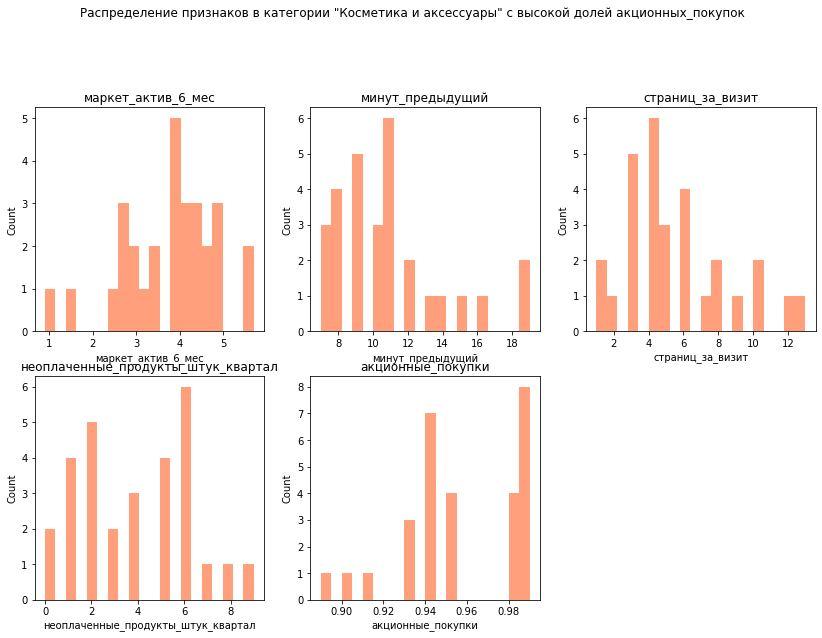

In [116]:
plt.figure(figsize=(14, 14))
p=1

for i in helper:
    plt.subplot(3, 3, p)
    sns.histplot(data=data.query('популярная_категория=="Косметика и аксессуары" and акционные_покупки>0.8')[i], 
                 bins=20, color='coral', edgecolor=None)
    plt.title(i)
    p+=1
plt.suptitle('Распределение признаков в категории "Косметика и аксессуары" с высокой долей акционных_покупок')
plt.show()

Видим плохие показатели признаков `минут_предыдущий` и `страниц_за_визит`.  

При этом довольно мало неоплаченных продуктов.  

**Такие пользователи заходят на сайт, зная, что им нужно. Редко откладывают покупку и не тратят много времени на сайте.**

**Вывод:**

Снизить долю покупок по акциям поможет вовлечение клиента в сервис, увеличение предложений и рекомендаций, увеличение маркетинговых коммуникаций.

**Предложения:** 

Поскольку для таких клиентов, очевидно, ключевую роль играет цена товара, было бы целесообразно предлагать им товар с низкой стоимостью:
* например, продукты бренда, которые могут являться аналогом более дорогого продукта



### **Выводы о сегментах**

Определены менее и более устойчивые сегменты.

Выявлено, что высокий риск снижения покупательской способности связан со следующими значениями признаков:
* маркет_актив_6_мес <= 3 
* минут_предыдущий <= 12.5 
* страниц_за_визит <=5 
* неоплаченные_продукты_штук_квартал > 6 
* акционные_покупки >= 0.4

Отдельно рассмотрен признак "Популярные категории":
* Наибольший показатель средней прибыли у категории Косметика и аксессуары.

Самые устойчивые категории: 
1. Мелкая бытовая техника и электроника
2. Техника для красоты и здоровья


**Категория Косметика и аксессуары** 

В категории Косметика и аксессуары - самой прибыльной - обнаружен высокий процент пользователей с высоким риском снижения покупательской активности:
* 36%

Анализ данных показал, что для клиентов, у которых снизилась активность, зачастую характерны все те же значения признаков, которые описывали ранее.

Что поможет удержать покупательскую активность клиента на прежнем уровне:
* Увеличение маркетинговых активностей 
* работа над вовлечением пользователя в сервис (например, больше качественных рекомендаций, чтобы он переходил по большему числу страниц)
* вовлечение в сервис пользователей, пользующихся им исключительно для покупок по скидкам/акциям

В результате этих улучшений пользовательская активность в рамках категории должна стать более устойчивой.

**Акционные покупки - категория Косметика и аксессуары**

Видно, что пользователи с высокой долей акционных покупок в среднем: 
* проводят меньше времени на сайте (признак `минут_текущий`)
* просматривают меньше страниц за визит

В разрезе категории Косметика и аксессуары обнаружено:

* Видим плохие показатели признаков `минут_предыдущий` и `страниц_за_визит`.  
* При этом довольно мало неоплаченных продуктов.    

Такие пользователи заходят на сайт, зная, что им нужно. Редко откладывают покупку и не тратят много времени на сайте.   
Также важно отметить, что среди этих пользователей фактически не встречается значение 6 и более признака `маркет_актив_6_мес`



**Предложения:**

Что поможет удержать покупательскую активность клиента на прежнем уровне:
* Увеличение маркетинговых активностей 
* работа над вовлечением пользователя в сервис (например, больше качественных рекомендаций, чтобы он переходил по большему числу страниц)
* вовлечение в сервис пользователей, пользующихся им исключительно для покупок по скидкам/акциям

Снижение доли покупок по акциям:
* Поскольку для таких клиентов, очевидно, ключевую роль играет цена товара, было бы целесообразно предлагать им товар с низкой стоимостью:  
  * например, продукты бренда, которые могут являться аналогом более дорогого продукта  


## **Общий вывод**

В ходе работы для интернет-магазина «В один клик» была: 
1. построена модель, определяющая вероятность снижения у пользователей покупательской активности
2. проведена сегментация покупателей 
3. изучена группа покупателей, даны рекомендации по увеличению покупательской активности

**Исходные данные и предобработка:**

Работа произведена с данными о пользователях интернет-магазина.  
4 датасета:
1. market_file - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_money - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. market_time - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. money - данные о среднемесячной прибыли покупателя за последние 3 месяца

Предобработка данных:  
* данные приведены к общему виду (названия столбцов и т.д.)
* удалены явные и неявные дубликаты
* в некоторых местах пропуски заменены на средние значения
* исправлены опечатки
* в дальнейшем датасеты объединены в одну таблицу

**Поиск лучшей модели:**  
Осуществлен с использованием пайплайна:
* кодирование признаков через OheEncoder и OrdinalEncoder, масштабирование (StandardScaler(), MinMaxScaler(), 'passthrough') в подготовке данных

Перебор гиперпараметров моделей:
* четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()
* гиперпараметры для них - n_neighbors, max_depth-max_features, C для l1-регулятора, degree poly для SVC 
* скейлеры: StandardScaler(), MinMaxScaler(), 'passthrough
* автоматический подбор способом RandomizedSearchCV

Метрика:
* ROC-AUC
* f1 (дополнительно)

Лучшая модель:
* LogisticRegression(C=15, penalty='l1', random_state=42, solver='liblinear')

Результат roc_auc_score:
* 0.909 - Кросс-валидационные данные
* 0.917 - Тестовые данные
* Дополнительно f1_score: 0.88 - Тестовые данные

**Выводы:**

Анализ важности признаков и сегментация покупателей показали:

Наименее устойчивые группы пользователей:
* маркет_актив_6_мес <= 3 
* минут_предыдущий <= 12.5 
* страниц_за_визит <=5 
* неоплаченные_продукты_штук_квартал > 6 
* акционные_покупки >= 0.4'

Наиболее устойчивые группы:
* доля акционных покупок <= 0.2
*  неоплаченных продуктов квартал <= 3
* страниц за визит >= 10
* средний просмотр страниц за визит >= 5
* потраченных минут за текущий и предыдущий период >= 15
* маркетинговые коммуникации за 6 месяцев, шт/мес >= 5

Самые устойчивые категории: 
* Мелкая бытовая техника и электроника
* Техника для красоты и здоровья

Наибольший показатель средней прибыли:
* категория Косметика и аксессуары.


**Предложения:**

1. Настройка уведомлений о неоплаченных продуктах
  * Будет полезно увеличить конверсию покупок из корзины. Скорее всего, надро обратить внимание на пользователей, которые редко покупают - добавляют в корзину, выходят из приложения и забывают о просмотренных страницах. 
2. Работа над рекомендациями, чтобы побуждать пользователя к просмотру большего числа страниц
  * Стоит увеличивать вовлеченность пользователя, улучшать приложение и делать больше качественных рекомендаций, чтобы он просматривал больше страниц и проводил больше времени в сервисе - так должен уменьшиться отток покупателей.
3. Общее улучшение пользовательского опыта
4. Увеличение среднего количества маркетинговых коммуникаций
5. Увеличегние минимального количества маркетинговых коммуникаций

______
**Пользователи с высокой долей акционных покупок**

Явно есть проблема с этими пользователями - они не заинтересованы в сервисе и пользуются только скидками.
* Если эту долю снизить, в дальнейшем их покупательская активность будет в меньшей степени зависеть от количества акций и скидок.

Возможное решение:
* Поскольку для таких клиентов, очевидно, ключевую роль играет цена товара, было бы целесообразно предлагать им товар с низкой стоимостью:  
  * например, продукты бренда, которые могут являться аналогом более дорогого продукта  